프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

* 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
* 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
* 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
* 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
* 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

### Pix2Pix (Generator)


In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

In [2]:
import os

data_path = os.getenv("HOME")+"/aiffel/cityscapes/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


#### 이미지 확인

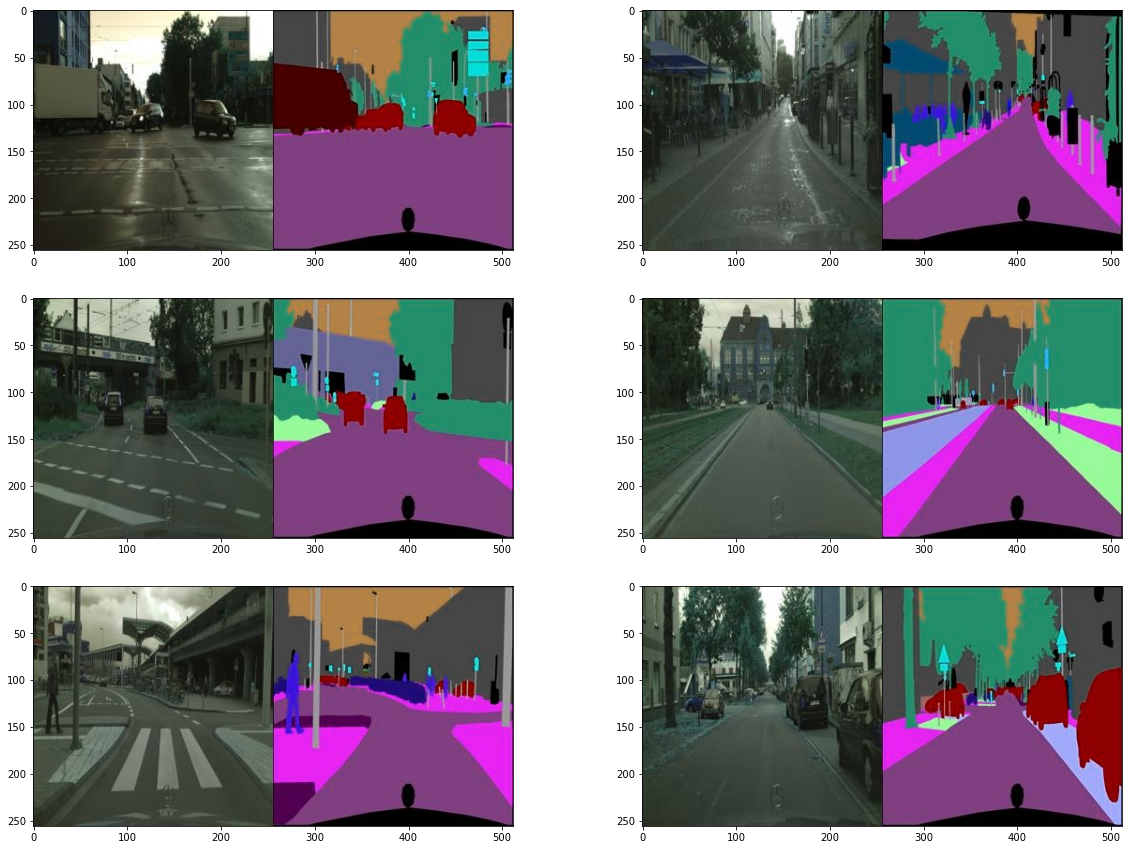

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))ㅁ
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


#### 데이터 전처리

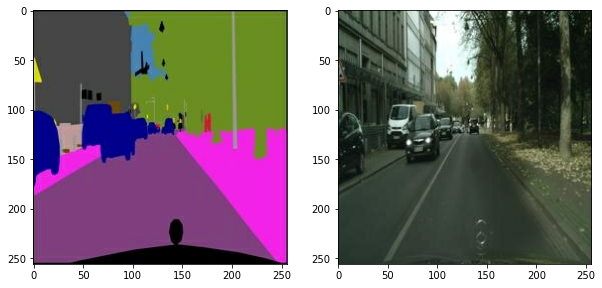

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

더 많은 데이터를 학습시키는 효과를 내기 위해 augmentation 방법을 적용

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


위와 같이 구성한 함수를 데이터에 적용해 시각화

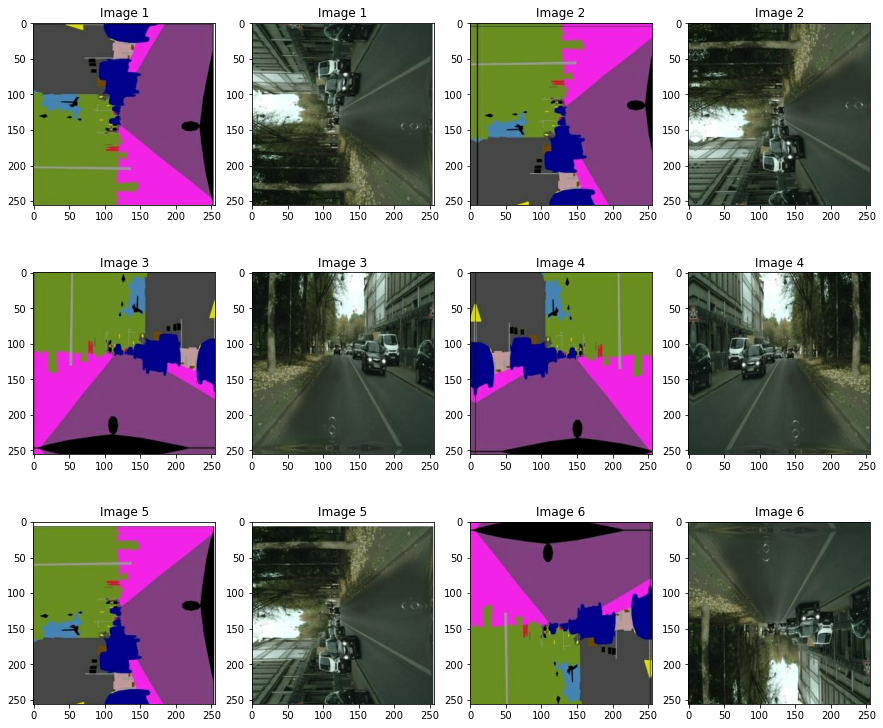

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

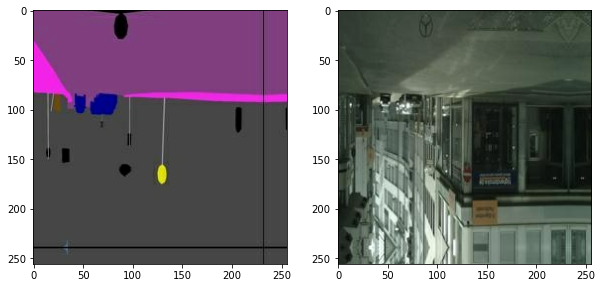

In [9]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### (2) Generator 구성하기

* 이제부터 본격적으로 Pix2Pix 구조를 구현
* Tensorflow의 Subclassing 방법을 이용

Generator 구현하기


In [10]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [11]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [12]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

#### Decoder를 구현

In [13]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [14]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

#### tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성

In [15]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### (3) Generator 재구성하기

In [16]:
# class EncodeBlock(layers.Layer):
#     def __init__(self, n_filters, use_bn=True):
#         super(EncodeBlock, self).__init__()
#         self.use_bn = use_bn       
#         self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
#         self.batchnorm = layers.BatchNormalization()
#         self.lrelu = layers.LeakyReLU(0.2)

#     def call(self, x):
#         x = self.conv(x)
#         if self.use_bn:
#             x = self.batchnorm(x)
#         return self.lrelu(x)

    
# class DecodeBlock(layers.Layer):
#     def __init__(self, f, dropout=True):
#         super(DecodeBlock, self).__init__()
#         self.dropout = dropout
#         self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
#         self.batchnorm = layers.BatchNormalization()
#         self.relu = layers.ReLU()
        
#     def call(self, x):
#         x = self.Transconv(x)
#         x = self.batchnorm(x)
#         if self.dropout:
#             x = layers.Dropout(.5)(x)
#         return self.relu(x)
    
# print("✅")

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [18]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### (4) Discriminator 구성하기

* 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요

### Discriminator 구현하기
* Discriminator의 구성요소 알아보기


In [19]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


#### 각 출력의 크기가 맞는지 확인

In [20]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


### Discriminator 생성

In [21]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [22]:
Discriminator().get_summary() 

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

#### 노이즈 생성

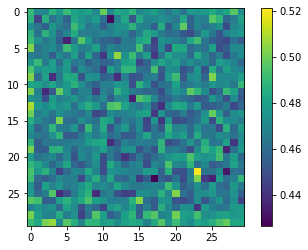

In [23]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

#### 두 가지 손실 함수를 모두 사용
* Generator 및 Discriminator의 손실 계산을 각각 정의

In [24]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


optimizer는 논문과 동일하게 아래와 같이 설정

In [25]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현

In [26]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


정의한 함수를 이용해서 학습을 진행

In [27]:
EPOCHS = 300

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8954                     
L1_loss:0.3726                     
Discriminator_loss:1.2733

EPOCH[1] - STEP[20]                     
Generator_loss:1.0199                     
L1_loss:0.2280                     
Discriminator_loss:1.2168

EPOCH[1] - STEP[30]                     
Generator_loss:0.8474                     
L1_loss:0.2049                     
Discriminator_loss:1.3254

EPOCH[1] - STEP[40]                     
Generator_loss:0.8131                     
L1_loss:0.1923                     
Discriminator_loss:1.2675

EPOCH[1] - STEP[50]                     
Generator_loss:0.8152                     
L1_loss:0.1752                     
Discriminator_loss:1.2291

EPOCH[1] - STEP[60]                     
Generator_loss:1.0139                     
L1_loss:0.2232                     
Discriminator_loss:1.0763

EPOCH[1] - STEP[70]                     
Generator_loss:0.8644                     
L1_loss:0.1683                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.2067                     
L1_loss:0.1571                     
Discriminator_loss:0.8304

EPOCH[3] - STEP[80]                     
Generator_loss:0.5402                     
L1_loss:0.1907                     
Discriminator_loss:1.5356

EPOCH[3] - STEP[90]                     
Generator_loss:1.8548                     
L1_loss:0.2059                     
Discriminator_loss:0.3536

EPOCH[3] - STEP[100]                     
Generator_loss:0.6983                     
L1_loss:0.1738                     
Discriminator_loss:1.0578

EPOCH[3] - STEP[110]                     
Generator_loss:2.9075                     
L1_loss:0.2177                     
Discriminator_loss:0.3671

EPOCH[3] - STEP[120]                     
Generator_loss:2.2149                     
L1_loss:0.1635                     
Discriminator_loss:1.0623

EPOCH[3] - STEP[130]                     
Generator_loss:3.0789                     
L1_loss:0.1861                

EPOCH[5] - STEP[130]                     
Generator_loss:0.4176                     
L1_loss:0.1748                     
Discriminator_loss:1.4052

EPOCH[5] - STEP[140]                     
Generator_loss:0.7925                     
L1_loss:0.1824                     
Discriminator_loss:1.3868

EPOCH[5] - STEP[150]                     
Generator_loss:1.7027                     
L1_loss:0.1723                     
Discriminator_loss:0.5890

EPOCH[5] - STEP[160]                     
Generator_loss:0.3326                     
L1_loss:0.1701                     
Discriminator_loss:1.5392

EPOCH[5] - STEP[170]                     
Generator_loss:2.0809                     
L1_loss:0.2120                     
Discriminator_loss:0.6274

EPOCH[5] - STEP[180]                     
Generator_loss:2.0515                     
L1_loss:0.1619                     
Discriminator_loss:0.5624

EPOCH[5] - STEP[190]                     
Generator_loss:0.6579                     
L1_loss:0.1973             

EPOCH[7] - STEP[190]                     
Generator_loss:2.5021                     
L1_loss:0.1573                     
Discriminator_loss:1.2191

EPOCH[7] - STEP[200]                     
Generator_loss:1.4070                     
L1_loss:0.1779                     
Discriminator_loss:0.5011

EPOCH[7] - STEP[210]                     
Generator_loss:1.2004                     
L1_loss:0.1448                     
Discriminator_loss:0.6691

EPOCH[7] - STEP[220]                     
Generator_loss:2.1179                     
L1_loss:0.2002                     
Discriminator_loss:0.4566

EPOCH[7] - STEP[230]                     
Generator_loss:0.9537                     
L1_loss:0.1691                     
Discriminator_loss:1.0654

EPOCH[7] - STEP[240]                     
Generator_loss:1.7973                     
L1_loss:0.1946                     
Discriminator_loss:0.5398

EPOCH[7] - STEP[250]                     
Generator_loss:2.4111                     
L1_loss:0.1609             

EPOCH[9] - STEP[250]                     
Generator_loss:0.7274                     
L1_loss:0.1842                     
Discriminator_loss:1.8228

EPOCH[10] - STEP[10]                     
Generator_loss:1.5851                     
L1_loss:0.2171                     
Discriminator_loss:0.3908

EPOCH[10] - STEP[20]                     
Generator_loss:3.3309                     
L1_loss:0.2081                     
Discriminator_loss:0.3529

EPOCH[10] - STEP[30]                     
Generator_loss:1.5041                     
L1_loss:0.1846                     
Discriminator_loss:0.4075

EPOCH[10] - STEP[40]                     
Generator_loss:0.8982                     
L1_loss:0.1949                     
Discriminator_loss:0.7866

EPOCH[10] - STEP[50]                     
Generator_loss:1.1462                     
L1_loss:0.1654                     
Discriminator_loss:0.7633

EPOCH[10] - STEP[60]                     
Generator_loss:1.3798                     
L1_loss:0.1894             

EPOCH[12] - STEP[60]                     
Generator_loss:0.8852                     
L1_loss:0.2076                     
Discriminator_loss:0.7131

EPOCH[12] - STEP[70]                     
Generator_loss:1.7579                     
L1_loss:0.1962                     
Discriminator_loss:0.5816

EPOCH[12] - STEP[80]                     
Generator_loss:1.6081                     
L1_loss:0.2221                     
Discriminator_loss:0.3644

EPOCH[12] - STEP[90]                     
Generator_loss:1.7823                     
L1_loss:0.1858                     
Discriminator_loss:0.3309

EPOCH[12] - STEP[100]                     
Generator_loss:1.2130                     
L1_loss:0.1756                     
Discriminator_loss:0.6064

EPOCH[12] - STEP[110]                     
Generator_loss:2.3170                     
L1_loss:0.1942                     
Discriminator_loss:0.2760

EPOCH[12] - STEP[120]                     
Generator_loss:0.9514                     
L1_loss:0.1555          

EPOCH[14] - STEP[120]                     
Generator_loss:1.7799                     
L1_loss:0.1591                     
Discriminator_loss:0.4860

EPOCH[14] - STEP[130]                     
Generator_loss:2.5579                     
L1_loss:0.1874                     
Discriminator_loss:0.7550

EPOCH[14] - STEP[140]                     
Generator_loss:1.3457                     
L1_loss:0.1975                     
Discriminator_loss:0.3685

EPOCH[14] - STEP[150]                     
Generator_loss:1.3635                     
L1_loss:0.1933                     
Discriminator_loss:0.6343

EPOCH[14] - STEP[160]                     
Generator_loss:1.1890                     
L1_loss:0.2069                     
Discriminator_loss:0.5638

EPOCH[14] - STEP[170]                     
Generator_loss:2.5081                     
L1_loss:0.1783                     
Discriminator_loss:0.9965

EPOCH[14] - STEP[180]                     
Generator_loss:1.3594                     
L1_loss:0.1743      

EPOCH[16] - STEP[180]                     
Generator_loss:0.7807                     
L1_loss:0.1697                     
Discriminator_loss:0.8626

EPOCH[16] - STEP[190]                     
Generator_loss:1.2679                     
L1_loss:0.2042                     
Discriminator_loss:0.5111

EPOCH[16] - STEP[200]                     
Generator_loss:1.3842                     
L1_loss:0.2064                     
Discriminator_loss:0.5651

EPOCH[16] - STEP[210]                     
Generator_loss:0.9163                     
L1_loss:0.1947                     
Discriminator_loss:0.6712

EPOCH[16] - STEP[220]                     
Generator_loss:1.4697                     
L1_loss:0.1859                     
Discriminator_loss:0.4584

EPOCH[16] - STEP[230]                     
Generator_loss:1.3116                     
L1_loss:0.1658                     
Discriminator_loss:1.1728

EPOCH[16] - STEP[240]                     
Generator_loss:1.7423                     
L1_loss:0.1657      

EPOCH[18] - STEP[240]                     
Generator_loss:1.2258                     
L1_loss:0.1847                     
Discriminator_loss:0.5162

EPOCH[18] - STEP[250]                     
Generator_loss:1.3990                     
L1_loss:0.1950                     
Discriminator_loss:0.6679

EPOCH[19] - STEP[10]                     
Generator_loss:0.9114                     
L1_loss:0.1894                     
Discriminator_loss:0.8909

EPOCH[19] - STEP[20]                     
Generator_loss:0.8666                     
L1_loss:0.1680                     
Discriminator_loss:0.6654

EPOCH[19] - STEP[30]                     
Generator_loss:2.7033                     
L1_loss:0.2078                     
Discriminator_loss:0.2238

EPOCH[19] - STEP[40]                     
Generator_loss:1.2862                     
L1_loss:0.1614                     
Discriminator_loss:0.9512

EPOCH[19] - STEP[50]                     
Generator_loss:2.5204                     
L1_loss:0.1662           

EPOCH[21] - STEP[50]                     
Generator_loss:1.1721                     
L1_loss:0.2125                     
Discriminator_loss:1.0668

EPOCH[21] - STEP[60]                     
Generator_loss:2.2274                     
L1_loss:0.1777                     
Discriminator_loss:0.4826

EPOCH[21] - STEP[70]                     
Generator_loss:1.3773                     
L1_loss:0.1795                     
Discriminator_loss:0.5117

EPOCH[21] - STEP[80]                     
Generator_loss:1.1535                     
L1_loss:0.1656                     
Discriminator_loss:0.7547

EPOCH[21] - STEP[90]                     
Generator_loss:1.0645                     
L1_loss:0.1873                     
Discriminator_loss:0.6062

EPOCH[21] - STEP[100]                     
Generator_loss:0.8509                     
L1_loss:0.1577                     
Discriminator_loss:0.7907

EPOCH[21] - STEP[110]                     
Generator_loss:1.7725                     
L1_loss:0.1822           

EPOCH[23] - STEP[110]                     
Generator_loss:0.9026                     
L1_loss:0.2026                     
Discriminator_loss:0.6863

EPOCH[23] - STEP[120]                     
Generator_loss:2.3854                     
L1_loss:0.1710                     
Discriminator_loss:0.6473

EPOCH[23] - STEP[130]                     
Generator_loss:1.5898                     
L1_loss:0.1603                     
Discriminator_loss:0.8642

EPOCH[23] - STEP[140]                     
Generator_loss:1.8844                     
L1_loss:0.2213                     
Discriminator_loss:1.3943

EPOCH[23] - STEP[150]                     
Generator_loss:0.5802                     
L1_loss:0.1921                     
Discriminator_loss:1.0213

EPOCH[23] - STEP[160]                     
Generator_loss:1.6706                     
L1_loss:0.1687                     
Discriminator_loss:0.8718

EPOCH[23] - STEP[170]                     
Generator_loss:1.1148                     
L1_loss:0.1608      

EPOCH[25] - STEP[170]                     
Generator_loss:1.8627                     
L1_loss:0.1766                     
Discriminator_loss:1.5673

EPOCH[25] - STEP[180]                     
Generator_loss:1.3320                     
L1_loss:0.1696                     
Discriminator_loss:0.5418

EPOCH[25] - STEP[190]                     
Generator_loss:0.9776                     
L1_loss:0.1628                     
Discriminator_loss:0.8324

EPOCH[25] - STEP[200]                     
Generator_loss:0.8717                     
L1_loss:0.1868                     
Discriminator_loss:0.8757

EPOCH[25] - STEP[210]                     
Generator_loss:0.6592                     
L1_loss:0.1806                     
Discriminator_loss:0.8753

EPOCH[25] - STEP[220]                     
Generator_loss:1.6291                     
L1_loss:0.1737                     
Discriminator_loss:0.4342

EPOCH[25] - STEP[230]                     
Generator_loss:1.1035                     
L1_loss:0.1983      

EPOCH[27] - STEP[230]                     
Generator_loss:2.2635                     
L1_loss:0.1745                     
Discriminator_loss:0.2366

EPOCH[27] - STEP[240]                     
Generator_loss:1.7003                     
L1_loss:0.1621                     
Discriminator_loss:0.6921

EPOCH[27] - STEP[250]                     
Generator_loss:1.6736                     
L1_loss:0.2075                     
Discriminator_loss:0.3278

EPOCH[28] - STEP[10]                     
Generator_loss:0.8223                     
L1_loss:0.1592                     
Discriminator_loss:0.8195

EPOCH[28] - STEP[20]                     
Generator_loss:1.2281                     
L1_loss:0.1919                     
Discriminator_loss:0.5471

EPOCH[28] - STEP[30]                     
Generator_loss:1.5660                     
L1_loss:0.1812                     
Discriminator_loss:0.3294

EPOCH[28] - STEP[40]                     
Generator_loss:1.6663                     
L1_loss:0.2098          

EPOCH[30] - STEP[40]                     
Generator_loss:0.8449                     
L1_loss:0.2118                     
Discriminator_loss:0.6884

EPOCH[30] - STEP[50]                     
Generator_loss:2.3301                     
L1_loss:0.1700                     
Discriminator_loss:0.7619

EPOCH[30] - STEP[60]                     
Generator_loss:1.0417                     
L1_loss:0.1989                     
Discriminator_loss:0.7550

EPOCH[30] - STEP[70]                     
Generator_loss:1.9793                     
L1_loss:0.1772                     
Discriminator_loss:0.5872

EPOCH[30] - STEP[80]                     
Generator_loss:1.9407                     
L1_loss:0.1739                     
Discriminator_loss:0.8677

EPOCH[30] - STEP[90]                     
Generator_loss:0.8533                     
L1_loss:0.1700                     
Discriminator_loss:1.3288

EPOCH[30] - STEP[100]                     
Generator_loss:2.7311                     
L1_loss:0.1599            

EPOCH[32] - STEP[100]                     
Generator_loss:0.8338                     
L1_loss:0.2062                     
Discriminator_loss:0.9500

EPOCH[32] - STEP[110]                     
Generator_loss:0.5504                     
L1_loss:0.1333                     
Discriminator_loss:1.5325

EPOCH[32] - STEP[120]                     
Generator_loss:0.7943                     
L1_loss:0.1777                     
Discriminator_loss:0.8697

EPOCH[32] - STEP[130]                     
Generator_loss:1.1519                     
L1_loss:0.1531                     
Discriminator_loss:1.1970

EPOCH[32] - STEP[140]                     
Generator_loss:1.7299                     
L1_loss:0.1893                     
Discriminator_loss:0.3450

EPOCH[32] - STEP[150]                     
Generator_loss:2.1764                     
L1_loss:0.1682                     
Discriminator_loss:0.9325

EPOCH[32] - STEP[160]                     
Generator_loss:0.9195                     
L1_loss:0.1831      

EPOCH[34] - STEP[160]                     
Generator_loss:0.6129                     
L1_loss:0.1602                     
Discriminator_loss:1.2898

EPOCH[34] - STEP[170]                     
Generator_loss:2.8524                     
L1_loss:0.1597                     
Discriminator_loss:0.7303

EPOCH[34] - STEP[180]                     
Generator_loss:2.3146                     
L1_loss:0.1861                     
Discriminator_loss:1.0224

EPOCH[34] - STEP[190]                     
Generator_loss:0.5233                     
L1_loss:0.1571                     
Discriminator_loss:1.4065

EPOCH[34] - STEP[200]                     
Generator_loss:1.1214                     
L1_loss:0.1620                     
Discriminator_loss:1.5306

EPOCH[34] - STEP[210]                     
Generator_loss:0.6448                     
L1_loss:0.1784                     
Discriminator_loss:1.1954

EPOCH[34] - STEP[220]                     
Generator_loss:1.2796                     
L1_loss:0.1677      

EPOCH[36] - STEP[220]                     
Generator_loss:2.1168                     
L1_loss:0.1894                     
Discriminator_loss:0.2598

EPOCH[36] - STEP[230]                     
Generator_loss:0.3802                     
L1_loss:0.1651                     
Discriminator_loss:1.4046

EPOCH[36] - STEP[240]                     
Generator_loss:0.5685                     
L1_loss:0.1742                     
Discriminator_loss:1.1529

EPOCH[36] - STEP[250]                     
Generator_loss:2.0930                     
L1_loss:0.1655                     
Discriminator_loss:0.8875

EPOCH[37] - STEP[10]                     
Generator_loss:2.3033                     
L1_loss:0.1661                     
Discriminator_loss:0.9549

EPOCH[37] - STEP[20]                     
Generator_loss:1.7955                     
L1_loss:0.1922                     
Discriminator_loss:0.2479

EPOCH[37] - STEP[30]                     
Generator_loss:1.9920                     
L1_loss:0.1623         

EPOCH[39] - STEP[30]                     
Generator_loss:1.0689                     
L1_loss:0.1676                     
Discriminator_loss:0.9585

EPOCH[39] - STEP[40]                     
Generator_loss:1.0711                     
L1_loss:0.1518                     
Discriminator_loss:1.2842

EPOCH[39] - STEP[50]                     
Generator_loss:0.7340                     
L1_loss:0.1822                     
Discriminator_loss:0.8329

EPOCH[39] - STEP[60]                     
Generator_loss:0.8730                     
L1_loss:0.1882                     
Discriminator_loss:0.6786

EPOCH[39] - STEP[70]                     
Generator_loss:1.0506                     
L1_loss:0.1811                     
Discriminator_loss:0.7957

EPOCH[39] - STEP[80]                     
Generator_loss:1.0022                     
L1_loss:0.1602                     
Discriminator_loss:0.9605

EPOCH[39] - STEP[90]                     
Generator_loss:2.2749                     
L1_loss:0.2054             

EPOCH[41] - STEP[90]                     
Generator_loss:1.2738                     
L1_loss:0.1696                     
Discriminator_loss:0.6996

EPOCH[41] - STEP[100]                     
Generator_loss:1.6105                     
L1_loss:0.1639                     
Discriminator_loss:1.5307

EPOCH[41] - STEP[110]                     
Generator_loss:1.4834                     
L1_loss:0.1901                     
Discriminator_loss:0.5149

EPOCH[41] - STEP[120]                     
Generator_loss:0.9775                     
L1_loss:0.2022                     
Discriminator_loss:1.7448

EPOCH[41] - STEP[130]                     
Generator_loss:0.8649                     
L1_loss:0.1795                     
Discriminator_loss:0.8062

EPOCH[41] - STEP[140]                     
Generator_loss:1.5138                     
L1_loss:0.1833                     
Discriminator_loss:0.5599

EPOCH[41] - STEP[150]                     
Generator_loss:2.6348                     
L1_loss:0.1594       

EPOCH[43] - STEP[150]                     
Generator_loss:1.5410                     
L1_loss:0.1711                     
Discriminator_loss:1.1324

EPOCH[43] - STEP[160]                     
Generator_loss:1.6450                     
L1_loss:0.1844                     
Discriminator_loss:0.9692

EPOCH[43] - STEP[170]                     
Generator_loss:1.6384                     
L1_loss:0.2135                     
Discriminator_loss:0.6525

EPOCH[43] - STEP[180]                     
Generator_loss:0.7595                     
L1_loss:0.1807                     
Discriminator_loss:0.9080

EPOCH[43] - STEP[190]                     
Generator_loss:2.7459                     
L1_loss:0.1676                     
Discriminator_loss:0.9847

EPOCH[43] - STEP[200]                     
Generator_loss:1.6779                     
L1_loss:0.1825                     
Discriminator_loss:0.8822

EPOCH[43] - STEP[210]                     
Generator_loss:0.9744                     
L1_loss:0.1830      

EPOCH[45] - STEP[210]                     
Generator_loss:2.3275                     
L1_loss:0.2179                     
Discriminator_loss:0.1650

EPOCH[45] - STEP[220]                     
Generator_loss:0.3575                     
L1_loss:0.1956                     
Discriminator_loss:1.4606

EPOCH[45] - STEP[230]                     
Generator_loss:1.1232                     
L1_loss:0.1846                     
Discriminator_loss:0.5537

EPOCH[45] - STEP[240]                     
Generator_loss:0.5345                     
L1_loss:0.1680                     
Discriminator_loss:1.2165

EPOCH[45] - STEP[250]                     
Generator_loss:1.1981                     
L1_loss:0.1732                     
Discriminator_loss:0.7483

EPOCH[46] - STEP[10]                     
Generator_loss:0.3629                     
L1_loss:0.1916                     
Discriminator_loss:1.5732

EPOCH[46] - STEP[20]                     
Generator_loss:1.7255                     
L1_loss:0.1662        

EPOCH[48] - STEP[20]                     
Generator_loss:1.6865                     
L1_loss:0.1660                     
Discriminator_loss:0.3672

EPOCH[48] - STEP[30]                     
Generator_loss:0.4723                     
L1_loss:0.1933                     
Discriminator_loss:1.1375

EPOCH[48] - STEP[40]                     
Generator_loss:2.3108                     
L1_loss:0.1863                     
Discriminator_loss:0.1547

EPOCH[48] - STEP[50]                     
Generator_loss:2.7585                     
L1_loss:0.1726                     
Discriminator_loss:0.5961

EPOCH[48] - STEP[60]                     
Generator_loss:2.8895                     
L1_loss:0.2002                     
Discriminator_loss:0.2117

EPOCH[48] - STEP[70]                     
Generator_loss:1.7842                     
L1_loss:0.2188                     
Discriminator_loss:0.2211

EPOCH[48] - STEP[80]                     
Generator_loss:1.3881                     
L1_loss:0.1595             

EPOCH[50] - STEP[80]                     
Generator_loss:2.0059                     
L1_loss:0.1417                     
Discriminator_loss:1.4849

EPOCH[50] - STEP[90]                     
Generator_loss:1.3543                     
L1_loss:0.2010                     
Discriminator_loss:0.3655

EPOCH[50] - STEP[100]                     
Generator_loss:1.1124                     
L1_loss:0.2109                     
Discriminator_loss:0.6647

EPOCH[50] - STEP[110]                     
Generator_loss:1.5510                     
L1_loss:0.1703                     
Discriminator_loss:1.0234

EPOCH[50] - STEP[120]                     
Generator_loss:1.4761                     
L1_loss:0.1808                     
Discriminator_loss:0.4614

EPOCH[50] - STEP[130]                     
Generator_loss:0.6605                     
L1_loss:0.1516                     
Discriminator_loss:1.2690

EPOCH[50] - STEP[140]                     
Generator_loss:1.0737                     
L1_loss:0.1862        

EPOCH[52] - STEP[140]                     
Generator_loss:1.7150                     
L1_loss:0.1926                     
Discriminator_loss:0.3241

EPOCH[52] - STEP[150]                     
Generator_loss:0.8170                     
L1_loss:0.1644                     
Discriminator_loss:0.8669

EPOCH[52] - STEP[160]                     
Generator_loss:1.7079                     
L1_loss:0.1953                     
Discriminator_loss:0.3454

EPOCH[52] - STEP[170]                     
Generator_loss:2.5924                     
L1_loss:0.1893                     
Discriminator_loss:0.2252

EPOCH[52] - STEP[180]                     
Generator_loss:1.4696                     
L1_loss:0.1640                     
Discriminator_loss:2.1345

EPOCH[52] - STEP[190]                     
Generator_loss:0.5648                     
L1_loss:0.1671                     
Discriminator_loss:1.0702

EPOCH[52] - STEP[200]                     
Generator_loss:2.2044                     
L1_loss:0.1682      

EPOCH[54] - STEP[200]                     
Generator_loss:1.0782                     
L1_loss:0.1787                     
Discriminator_loss:0.6648

EPOCH[54] - STEP[210]                     
Generator_loss:1.6825                     
L1_loss:0.1913                     
Discriminator_loss:0.6469

EPOCH[54] - STEP[220]                     
Generator_loss:1.9353                     
L1_loss:0.1653                     
Discriminator_loss:0.6981

EPOCH[54] - STEP[230]                     
Generator_loss:2.4874                     
L1_loss:0.1733                     
Discriminator_loss:1.0382

EPOCH[54] - STEP[240]                     
Generator_loss:1.9669                     
L1_loss:0.1840                     
Discriminator_loss:0.3847

EPOCH[54] - STEP[250]                     
Generator_loss:1.2144                     
L1_loss:0.1565                     
Discriminator_loss:2.1974

EPOCH[55] - STEP[10]                     
Generator_loss:1.8672                     
L1_loss:0.2025       

EPOCH[57] - STEP[10]                     
Generator_loss:1.6415                     
L1_loss:0.1921                     
Discriminator_loss:1.1634

EPOCH[57] - STEP[20]                     
Generator_loss:1.2440                     
L1_loss:0.1697                     
Discriminator_loss:1.3635

EPOCH[57] - STEP[30]                     
Generator_loss:2.2983                     
L1_loss:0.1781                     
Discriminator_loss:0.5132

EPOCH[57] - STEP[40]                     
Generator_loss:2.8726                     
L1_loss:0.1855                     
Discriminator_loss:0.2959

EPOCH[57] - STEP[50]                     
Generator_loss:2.0920                     
L1_loss:0.1695                     
Discriminator_loss:0.3793

EPOCH[57] - STEP[60]                     
Generator_loss:2.2482                     
L1_loss:0.1576                     
Discriminator_loss:1.5016

EPOCH[57] - STEP[70]                     
Generator_loss:0.9247                     
L1_loss:0.1698             

EPOCH[59] - STEP[70]                     
Generator_loss:1.0834                     
L1_loss:0.1673                     
Discriminator_loss:1.2027

EPOCH[59] - STEP[80]                     
Generator_loss:1.9717                     
L1_loss:0.1504                     
Discriminator_loss:1.2459

EPOCH[59] - STEP[90]                     
Generator_loss:1.6316                     
L1_loss:0.1861                     
Discriminator_loss:0.4156

EPOCH[59] - STEP[100]                     
Generator_loss:0.9344                     
L1_loss:0.1796                     
Discriminator_loss:1.0728

EPOCH[59] - STEP[110]                     
Generator_loss:2.1288                     
L1_loss:0.1652                     
Discriminator_loss:0.6676

EPOCH[59] - STEP[120]                     
Generator_loss:1.8941                     
L1_loss:0.1658                     
Discriminator_loss:0.2882

EPOCH[59] - STEP[130]                     
Generator_loss:1.0986                     
L1_loss:0.1749         

EPOCH[61] - STEP[130]                     
Generator_loss:1.7827                     
L1_loss:0.1446                     
Discriminator_loss:1.8912

EPOCH[61] - STEP[140]                     
Generator_loss:2.5280                     
L1_loss:0.1993                     
Discriminator_loss:0.4388

EPOCH[61] - STEP[150]                     
Generator_loss:2.1384                     
L1_loss:0.1592                     
Discriminator_loss:1.4173

EPOCH[61] - STEP[160]                     
Generator_loss:1.3401                     
L1_loss:0.1663                     
Discriminator_loss:0.4220

EPOCH[61] - STEP[170]                     
Generator_loss:1.1171                     
L1_loss:0.1844                     
Discriminator_loss:0.5024

EPOCH[61] - STEP[180]                     
Generator_loss:1.7661                     
L1_loss:0.1974                     
Discriminator_loss:0.2848

EPOCH[61] - STEP[190]                     
Generator_loss:1.2346                     
L1_loss:0.1801      

EPOCH[63] - STEP[190]                     
Generator_loss:1.5463                     
L1_loss:0.1679                     
Discriminator_loss:0.6666

EPOCH[63] - STEP[200]                     
Generator_loss:1.2371                     
L1_loss:0.2077                     
Discriminator_loss:0.3952

EPOCH[63] - STEP[210]                     
Generator_loss:1.2379                     
L1_loss:0.1591                     
Discriminator_loss:0.6562

EPOCH[63] - STEP[220]                     
Generator_loss:2.1334                     
L1_loss:0.1738                     
Discriminator_loss:0.9322

EPOCH[63] - STEP[230]                     
Generator_loss:1.1296                     
L1_loss:0.1669                     
Discriminator_loss:0.8560

EPOCH[63] - STEP[240]                     
Generator_loss:1.9610                     
L1_loss:0.1960                     
Discriminator_loss:2.0639

EPOCH[63] - STEP[250]                     
Generator_loss:1.4416                     
L1_loss:0.1286      

EPOCH[65] - STEP[250]                     
Generator_loss:1.2182                     
L1_loss:0.1643                     
Discriminator_loss:0.5366

EPOCH[66] - STEP[10]                     
Generator_loss:0.9741                     
L1_loss:0.1570                     
Discriminator_loss:0.7401

EPOCH[66] - STEP[20]                     
Generator_loss:0.7834                     
L1_loss:0.1596                     
Discriminator_loss:1.6091

EPOCH[66] - STEP[30]                     
Generator_loss:0.4481                     
L1_loss:0.1577                     
Discriminator_loss:1.7009

EPOCH[66] - STEP[40]                     
Generator_loss:1.2593                     
L1_loss:0.1743                     
Discriminator_loss:0.5137

EPOCH[66] - STEP[50]                     
Generator_loss:1.5781                     
L1_loss:0.1869                     
Discriminator_loss:0.5066

EPOCH[66] - STEP[60]                     
Generator_loss:1.4567                     
L1_loss:0.1862            

EPOCH[68] - STEP[60]                     
Generator_loss:1.2679                     
L1_loss:0.1893                     
Discriminator_loss:0.4073

EPOCH[68] - STEP[70]                     
Generator_loss:1.8177                     
L1_loss:0.1655                     
Discriminator_loss:1.0751

EPOCH[68] - STEP[80]                     
Generator_loss:2.0693                     
L1_loss:0.1789                     
Discriminator_loss:0.7772

EPOCH[68] - STEP[90]                     
Generator_loss:1.8375                     
L1_loss:0.2027                     
Discriminator_loss:0.3366

EPOCH[68] - STEP[100]                     
Generator_loss:1.5594                     
L1_loss:0.1616                     
Discriminator_loss:0.4975

EPOCH[68] - STEP[110]                     
Generator_loss:1.6193                     
L1_loss:0.1929                     
Discriminator_loss:1.2849

EPOCH[68] - STEP[120]                     
Generator_loss:1.5903                     
L1_loss:0.1438          

EPOCH[70] - STEP[120]                     
Generator_loss:2.0099                     
L1_loss:0.1777                     
Discriminator_loss:0.3158

EPOCH[70] - STEP[130]                     
Generator_loss:1.2169                     
L1_loss:0.1549                     
Discriminator_loss:0.4801

EPOCH[70] - STEP[140]                     
Generator_loss:0.4551                     
L1_loss:0.1727                     
Discriminator_loss:1.3733

EPOCH[70] - STEP[150]                     
Generator_loss:2.3488                     
L1_loss:0.1850                     
Discriminator_loss:0.2898

EPOCH[70] - STEP[160]                     
Generator_loss:0.9076                     
L1_loss:0.1491                     
Discriminator_loss:1.0107

EPOCH[70] - STEP[170]                     
Generator_loss:1.0992                     
L1_loss:0.1915                     
Discriminator_loss:0.6867

EPOCH[70] - STEP[180]                     
Generator_loss:0.4877                     
L1_loss:0.1685      

EPOCH[72] - STEP[180]                     
Generator_loss:1.6861                     
L1_loss:0.1652                     
Discriminator_loss:0.6781

EPOCH[72] - STEP[190]                     
Generator_loss:1.3644                     
L1_loss:0.1536                     
Discriminator_loss:0.8664

EPOCH[72] - STEP[200]                     
Generator_loss:2.1923                     
L1_loss:0.1578                     
Discriminator_loss:1.4607

EPOCH[72] - STEP[210]                     
Generator_loss:1.1432                     
L1_loss:0.2263                     
Discriminator_loss:0.4368

EPOCH[72] - STEP[220]                     
Generator_loss:1.7616                     
L1_loss:0.1906                     
Discriminator_loss:0.3707

EPOCH[72] - STEP[230]                     
Generator_loss:1.6009                     
L1_loss:0.1717                     
Discriminator_loss:1.5734

EPOCH[72] - STEP[240]                     
Generator_loss:1.4989                     
L1_loss:0.1820      

EPOCH[74] - STEP[240]                     
Generator_loss:2.2315                     
L1_loss:0.1629                     
Discriminator_loss:3.2002

EPOCH[74] - STEP[250]                     
Generator_loss:1.7524                     
L1_loss:0.1669                     
Discriminator_loss:0.6739

EPOCH[75] - STEP[10]                     
Generator_loss:0.8277                     
L1_loss:0.1665                     
Discriminator_loss:1.7796

EPOCH[75] - STEP[20]                     
Generator_loss:1.5090                     
L1_loss:0.1834                     
Discriminator_loss:0.7748

EPOCH[75] - STEP[30]                     
Generator_loss:1.4166                     
L1_loss:0.2025                     
Discriminator_loss:0.3893

EPOCH[75] - STEP[40]                     
Generator_loss:0.9126                     
L1_loss:0.1734                     
Discriminator_loss:1.0176

EPOCH[75] - STEP[50]                     
Generator_loss:2.9515                     
L1_loss:0.1623           

EPOCH[77] - STEP[50]                     
Generator_loss:0.5236                     
L1_loss:0.1556                     
Discriminator_loss:1.0990

EPOCH[77] - STEP[60]                     
Generator_loss:2.3285                     
L1_loss:0.1564                     
Discriminator_loss:3.6508

EPOCH[77] - STEP[70]                     
Generator_loss:1.6832                     
L1_loss:0.1774                     
Discriminator_loss:0.3321

EPOCH[77] - STEP[80]                     
Generator_loss:1.0801                     
L1_loss:0.1541                     
Discriminator_loss:0.7950

EPOCH[77] - STEP[90]                     
Generator_loss:2.0857                     
L1_loss:0.1773                     
Discriminator_loss:0.6874

EPOCH[77] - STEP[100]                     
Generator_loss:1.0481                     
L1_loss:0.1802                     
Discriminator_loss:0.7288

EPOCH[77] - STEP[110]                     
Generator_loss:2.2591                     
L1_loss:0.1593           

EPOCH[79] - STEP[110]                     
Generator_loss:1.4052                     
L1_loss:0.1805                     
Discriminator_loss:0.4929

EPOCH[79] - STEP[120]                     
Generator_loss:2.4571                     
L1_loss:0.2017                     
Discriminator_loss:0.1975

EPOCH[79] - STEP[130]                     
Generator_loss:1.8707                     
L1_loss:0.1868                     
Discriminator_loss:0.2370

EPOCH[79] - STEP[140]                     
Generator_loss:1.3903                     
L1_loss:0.1593                     
Discriminator_loss:1.0583

EPOCH[79] - STEP[150]                     
Generator_loss:1.4339                     
L1_loss:0.1800                     
Discriminator_loss:0.6396

EPOCH[79] - STEP[160]                     
Generator_loss:1.6367                     
L1_loss:0.1861                     
Discriminator_loss:0.3296

EPOCH[79] - STEP[170]                     
Generator_loss:1.3622                     
L1_loss:0.1594      

EPOCH[81] - STEP[170]                     
Generator_loss:1.5430                     
L1_loss:0.1377                     
Discriminator_loss:1.2484

EPOCH[81] - STEP[180]                     
Generator_loss:1.1955                     
L1_loss:0.1989                     
Discriminator_loss:0.5607

EPOCH[81] - STEP[190]                     
Generator_loss:3.0217                     
L1_loss:0.1445                     
Discriminator_loss:2.5582

EPOCH[81] - STEP[200]                     
Generator_loss:1.4943                     
L1_loss:0.1770                     
Discriminator_loss:1.0166

EPOCH[81] - STEP[210]                     
Generator_loss:0.4401                     
L1_loss:0.1590                     
Discriminator_loss:1.2910

EPOCH[81] - STEP[220]                     
Generator_loss:1.0927                     
L1_loss:0.1895                     
Discriminator_loss:0.5023

EPOCH[81] - STEP[230]                     
Generator_loss:2.1190                     
L1_loss:0.1600      

EPOCH[83] - STEP[230]                     
Generator_loss:1.6621                     
L1_loss:0.1762                     
Discriminator_loss:0.3359

EPOCH[83] - STEP[240]                     
Generator_loss:2.1678                     
L1_loss:0.1717                     
Discriminator_loss:1.0734

EPOCH[83] - STEP[250]                     
Generator_loss:1.8258                     
L1_loss:0.1515                     
Discriminator_loss:1.0949

EPOCH[84] - STEP[10]                     
Generator_loss:0.6105                     
L1_loss:0.2005                     
Discriminator_loss:0.9085

EPOCH[84] - STEP[20]                     
Generator_loss:2.7734                     
L1_loss:0.1684                     
Discriminator_loss:0.7666

EPOCH[84] - STEP[30]                     
Generator_loss:1.3204                     
L1_loss:0.1634                     
Discriminator_loss:0.8114

EPOCH[84] - STEP[40]                     
Generator_loss:1.7292                     
L1_loss:0.1960          

EPOCH[86] - STEP[40]                     
Generator_loss:1.6005                     
L1_loss:0.1772                     
Discriminator_loss:2.0032

EPOCH[86] - STEP[50]                     
Generator_loss:1.3711                     
L1_loss:0.1798                     
Discriminator_loss:0.4252

EPOCH[86] - STEP[60]                     
Generator_loss:1.2515                     
L1_loss:0.1838                     
Discriminator_loss:0.4893

EPOCH[86] - STEP[70]                     
Generator_loss:0.9469                     
L1_loss:0.1989                     
Discriminator_loss:0.5860

EPOCH[86] - STEP[80]                     
Generator_loss:0.7806                     
L1_loss:0.2223                     
Discriminator_loss:0.7573

EPOCH[86] - STEP[90]                     
Generator_loss:2.5667                     
L1_loss:0.1934                     
Discriminator_loss:0.3812

EPOCH[86] - STEP[100]                     
Generator_loss:1.0747                     
L1_loss:0.1806            

EPOCH[88] - STEP[100]                     
Generator_loss:0.8468                     
L1_loss:0.1800                     
Discriminator_loss:0.7599

EPOCH[88] - STEP[110]                     
Generator_loss:0.9901                     
L1_loss:0.1690                     
Discriminator_loss:0.7200

EPOCH[88] - STEP[120]                     
Generator_loss:1.6150                     
L1_loss:0.1844                     
Discriminator_loss:0.5779

EPOCH[88] - STEP[130]                     
Generator_loss:1.4026                     
L1_loss:0.1488                     
Discriminator_loss:1.2054

EPOCH[88] - STEP[140]                     
Generator_loss:1.8917                     
L1_loss:0.1915                     
Discriminator_loss:0.7306

EPOCH[88] - STEP[150]                     
Generator_loss:0.7189                     
L1_loss:0.1491                     
Discriminator_loss:0.9992

EPOCH[88] - STEP[160]                     
Generator_loss:1.5579                     
L1_loss:0.1523      

EPOCH[90] - STEP[160]                     
Generator_loss:1.5574                     
L1_loss:0.1819                     
Discriminator_loss:0.3512

EPOCH[90] - STEP[170]                     
Generator_loss:2.1921                     
L1_loss:0.1600                     
Discriminator_loss:1.6728

EPOCH[90] - STEP[180]                     
Generator_loss:1.9458                     
L1_loss:0.1819                     
Discriminator_loss:1.1360

EPOCH[90] - STEP[190]                     
Generator_loss:0.7787                     
L1_loss:0.1385                     
Discriminator_loss:2.2135

EPOCH[90] - STEP[200]                     
Generator_loss:1.1967                     
L1_loss:0.1541                     
Discriminator_loss:1.0450

EPOCH[90] - STEP[210]                     
Generator_loss:2.2740                     
L1_loss:0.1428                     
Discriminator_loss:0.6410

EPOCH[90] - STEP[220]                     
Generator_loss:1.9333                     
L1_loss:0.1724      

EPOCH[92] - STEP[220]                     
Generator_loss:1.2688                     
L1_loss:0.1588                     
Discriminator_loss:0.9327

EPOCH[92] - STEP[230]                     
Generator_loss:0.7419                     
L1_loss:0.1547                     
Discriminator_loss:0.9433

EPOCH[92] - STEP[240]                     
Generator_loss:1.8922                     
L1_loss:0.1685                     
Discriminator_loss:1.5330

EPOCH[92] - STEP[250]                     
Generator_loss:1.9884                     
L1_loss:0.1619                     
Discriminator_loss:1.1426

EPOCH[93] - STEP[10]                     
Generator_loss:1.4370                     
L1_loss:0.1723                     
Discriminator_loss:0.6171

EPOCH[93] - STEP[20]                     
Generator_loss:2.1940                     
L1_loss:0.1787                     
Discriminator_loss:0.4707

EPOCH[93] - STEP[30]                     
Generator_loss:1.1396                     
L1_loss:0.1771         

EPOCH[95] - STEP[30]                     
Generator_loss:1.4792                     
L1_loss:0.1953                     
Discriminator_loss:0.3227

EPOCH[95] - STEP[40]                     
Generator_loss:1.5639                     
L1_loss:0.1562                     
Discriminator_loss:0.5772

EPOCH[95] - STEP[50]                     
Generator_loss:0.5626                     
L1_loss:0.1626                     
Discriminator_loss:1.3895

EPOCH[95] - STEP[60]                     
Generator_loss:0.9076                     
L1_loss:0.1722                     
Discriminator_loss:0.9203

EPOCH[95] - STEP[70]                     
Generator_loss:1.2098                     
L1_loss:0.1766                     
Discriminator_loss:0.8262

EPOCH[95] - STEP[80]                     
Generator_loss:1.0178                     
L1_loss:0.2111                     
Discriminator_loss:0.5249

EPOCH[95] - STEP[90]                     
Generator_loss:1.1875                     
L1_loss:0.1803             

EPOCH[97] - STEP[90]                     
Generator_loss:0.8654                     
L1_loss:0.1670                     
Discriminator_loss:1.6845

EPOCH[97] - STEP[100]                     
Generator_loss:0.8470                     
L1_loss:0.1897                     
Discriminator_loss:0.7661

EPOCH[97] - STEP[110]                     
Generator_loss:1.3134                     
L1_loss:0.1765                     
Discriminator_loss:0.4156

EPOCH[97] - STEP[120]                     
Generator_loss:2.4335                     
L1_loss:0.2087                     
Discriminator_loss:0.5335

EPOCH[97] - STEP[130]                     
Generator_loss:0.7685                     
L1_loss:0.1800                     
Discriminator_loss:0.8215

EPOCH[97] - STEP[140]                     
Generator_loss:1.0675                     
L1_loss:0.1546                     
Discriminator_loss:0.5757

EPOCH[97] - STEP[150]                     
Generator_loss:1.6347                     
L1_loss:0.1518       

EPOCH[99] - STEP[150]                     
Generator_loss:1.0186                     
L1_loss:0.2044                     
Discriminator_loss:0.5181

EPOCH[99] - STEP[160]                     
Generator_loss:1.0763                     
L1_loss:0.1920                     
Discriminator_loss:0.5082

EPOCH[99] - STEP[170]                     
Generator_loss:0.9341                     
L1_loss:0.1832                     
Discriminator_loss:0.8170

EPOCH[99] - STEP[180]                     
Generator_loss:1.6766                     
L1_loss:0.1727                     
Discriminator_loss:1.1888

EPOCH[99] - STEP[190]                     
Generator_loss:1.6327                     
L1_loss:0.1810                     
Discriminator_loss:0.2785

EPOCH[99] - STEP[200]                     
Generator_loss:1.4186                     
L1_loss:0.1533                     
Discriminator_loss:1.7994

EPOCH[99] - STEP[210]                     
Generator_loss:2.9454                     
L1_loss:0.2277      

EPOCH[101] - STEP[200]                     
Generator_loss:2.0318                     
L1_loss:0.1910                     
Discriminator_loss:2.0756

EPOCH[101] - STEP[210]                     
Generator_loss:0.5158                     
L1_loss:0.2196                     
Discriminator_loss:1.0642

EPOCH[101] - STEP[220]                     
Generator_loss:0.7188                     
L1_loss:0.1429                     
Discriminator_loss:1.6813

EPOCH[101] - STEP[230]                     
Generator_loss:0.7442                     
L1_loss:0.1516                     
Discriminator_loss:1.1452

EPOCH[101] - STEP[240]                     
Generator_loss:2.0956                     
L1_loss:0.1858                     
Discriminator_loss:0.2289

EPOCH[101] - STEP[250]                     
Generator_loss:0.5785                     
L1_loss:0.1906                     
Discriminator_loss:1.0095

EPOCH[102] - STEP[10]                     
Generator_loss:0.5129                     
L1_loss:0.1794

EPOCH[103] - STEP[250]                     
Generator_loss:1.3644                     
L1_loss:0.1470                     
Discriminator_loss:0.5556

EPOCH[104] - STEP[10]                     
Generator_loss:0.8515                     
L1_loss:0.1696                     
Discriminator_loss:0.8839

EPOCH[104] - STEP[20]                     
Generator_loss:1.4557                     
L1_loss:0.2081                     
Discriminator_loss:0.3412

EPOCH[104] - STEP[30]                     
Generator_loss:1.8440                     
L1_loss:0.1825                     
Discriminator_loss:0.7794

EPOCH[104] - STEP[40]                     
Generator_loss:2.3942                     
L1_loss:0.1620                     
Discriminator_loss:2.3655

EPOCH[104] - STEP[50]                     
Generator_loss:2.1243                     
L1_loss:0.1808                     
Discriminator_loss:0.1956

EPOCH[104] - STEP[60]                     
Generator_loss:1.5190                     
L1_loss:0.1750     

EPOCH[106] - STEP[50]                     
Generator_loss:1.9410                     
L1_loss:0.1973                     
Discriminator_loss:0.2387

EPOCH[106] - STEP[60]                     
Generator_loss:1.2390                     
L1_loss:0.1839                     
Discriminator_loss:0.5165

EPOCH[106] - STEP[70]                     
Generator_loss:1.2176                     
L1_loss:0.1720                     
Discriminator_loss:0.4932

EPOCH[106] - STEP[80]                     
Generator_loss:1.0701                     
L1_loss:0.1698                     
Discriminator_loss:0.5066

EPOCH[106] - STEP[90]                     
Generator_loss:1.9964                     
L1_loss:0.1464                     
Discriminator_loss:1.4468

EPOCH[106] - STEP[100]                     
Generator_loss:1.8662                     
L1_loss:0.1719                     
Discriminator_loss:0.2113

EPOCH[106] - STEP[110]                     
Generator_loss:1.4325                     
L1_loss:0.1571    

EPOCH[108] - STEP[100]                     
Generator_loss:1.6925                     
L1_loss:0.1524                     
Discriminator_loss:0.6625

EPOCH[108] - STEP[110]                     
Generator_loss:1.3367                     
L1_loss:0.1862                     
Discriminator_loss:0.6723

EPOCH[108] - STEP[120]                     
Generator_loss:2.5051                     
L1_loss:0.1546                     
Discriminator_loss:0.8983

EPOCH[108] - STEP[130]                     
Generator_loss:2.2129                     
L1_loss:0.1516                     
Discriminator_loss:0.5099

EPOCH[108] - STEP[140]                     
Generator_loss:2.6299                     
L1_loss:0.1791                     
Discriminator_loss:1.4239

EPOCH[108] - STEP[150]                     
Generator_loss:0.9206                     
L1_loss:0.1576                     
Discriminator_loss:1.0436

EPOCH[108] - STEP[160]                     
Generator_loss:0.7366                     
L1_loss:0.191

EPOCH[110] - STEP[150]                     
Generator_loss:0.9641                     
L1_loss:0.1793                     
Discriminator_loss:0.7208

EPOCH[110] - STEP[160]                     
Generator_loss:0.9919                     
L1_loss:0.1346                     
Discriminator_loss:1.3149

EPOCH[110] - STEP[170]                     
Generator_loss:1.3837                     
L1_loss:0.1644                     
Discriminator_loss:1.4185

EPOCH[110] - STEP[180]                     
Generator_loss:1.6025                     
L1_loss:0.1747                     
Discriminator_loss:0.7518

EPOCH[110] - STEP[190]                     
Generator_loss:2.0034                     
L1_loss:0.1445                     
Discriminator_loss:1.4279

EPOCH[110] - STEP[200]                     
Generator_loss:1.8200                     
L1_loss:0.2013                     
Discriminator_loss:0.3301

EPOCH[110] - STEP[210]                     
Generator_loss:0.8836                     
L1_loss:0.156

EPOCH[112] - STEP[200]                     
Generator_loss:1.5939                     
L1_loss:0.1678                     
Discriminator_loss:0.3465

EPOCH[112] - STEP[210]                     
Generator_loss:0.2222                     
L1_loss:0.1752                     
Discriminator_loss:2.6300

EPOCH[112] - STEP[220]                     
Generator_loss:0.7996                     
L1_loss:0.1831                     
Discriminator_loss:0.8528

EPOCH[112] - STEP[230]                     
Generator_loss:1.6460                     
L1_loss:0.1712                     
Discriminator_loss:0.3920

EPOCH[112] - STEP[240]                     
Generator_loss:1.4840                     
L1_loss:0.1576                     
Discriminator_loss:1.1796

EPOCH[112] - STEP[250]                     
Generator_loss:1.6039                     
L1_loss:0.1863                     
Discriminator_loss:0.4451

EPOCH[113] - STEP[10]                     
Generator_loss:0.6790                     
L1_loss:0.1677

EPOCH[114] - STEP[250]                     
Generator_loss:0.7390                     
L1_loss:0.2104                     
Discriminator_loss:0.8099

EPOCH[115] - STEP[10]                     
Generator_loss:0.7304                     
L1_loss:0.2115                     
Discriminator_loss:0.9610

EPOCH[115] - STEP[20]                     
Generator_loss:1.5268                     
L1_loss:0.1812                     
Discriminator_loss:0.6756

EPOCH[115] - STEP[30]                     
Generator_loss:1.1724                     
L1_loss:0.1729                     
Discriminator_loss:0.8942

EPOCH[115] - STEP[40]                     
Generator_loss:0.9128                     
L1_loss:0.1707                     
Discriminator_loss:0.6557

EPOCH[115] - STEP[50]                     
Generator_loss:1.5267                     
L1_loss:0.1855                     
Discriminator_loss:0.4425

EPOCH[115] - STEP[60]                     
Generator_loss:0.6211                     
L1_loss:0.1396     

EPOCH[117] - STEP[50]                     
Generator_loss:1.6469                     
L1_loss:0.1658                     
Discriminator_loss:1.5510

EPOCH[117] - STEP[60]                     
Generator_loss:1.5219                     
L1_loss:0.1962                     
Discriminator_loss:0.5083

EPOCH[117] - STEP[70]                     
Generator_loss:1.5123                     
L1_loss:0.1508                     
Discriminator_loss:1.6480

EPOCH[117] - STEP[80]                     
Generator_loss:1.3427                     
L1_loss:0.1509                     
Discriminator_loss:0.6456

EPOCH[117] - STEP[90]                     
Generator_loss:2.2831                     
L1_loss:0.1550                     
Discriminator_loss:1.2229

EPOCH[117] - STEP[100]                     
Generator_loss:1.0555                     
L1_loss:0.1760                     
Discriminator_loss:0.5568

EPOCH[117] - STEP[110]                     
Generator_loss:1.2262                     
L1_loss:0.1672    

EPOCH[119] - STEP[100]                     
Generator_loss:0.7018                     
L1_loss:0.1825                     
Discriminator_loss:0.8890

EPOCH[119] - STEP[110]                     
Generator_loss:0.9214                     
L1_loss:0.1439                     
Discriminator_loss:2.0368

EPOCH[119] - STEP[120]                     
Generator_loss:1.8230                     
L1_loss:0.1788                     
Discriminator_loss:0.8688

EPOCH[119] - STEP[130]                     
Generator_loss:1.0790                     
L1_loss:0.1402                     
Discriminator_loss:0.6716

EPOCH[119] - STEP[140]                     
Generator_loss:1.6433                     
L1_loss:0.1586                     
Discriminator_loss:1.2752

EPOCH[119] - STEP[150]                     
Generator_loss:0.8081                     
L1_loss:0.1620                     
Discriminator_loss:2.0044

EPOCH[119] - STEP[160]                     
Generator_loss:2.1208                     
L1_loss:0.155

EPOCH[121] - STEP[150]                     
Generator_loss:1.8841                     
L1_loss:0.1963                     
Discriminator_loss:0.4987

EPOCH[121] - STEP[160]                     
Generator_loss:1.1315                     
L1_loss:0.2096                     
Discriminator_loss:0.4772

EPOCH[121] - STEP[170]                     
Generator_loss:0.8015                     
L1_loss:0.1835                     
Discriminator_loss:1.0159

EPOCH[121] - STEP[180]                     
Generator_loss:2.1066                     
L1_loss:0.1658                     
Discriminator_loss:1.0569

EPOCH[121] - STEP[190]                     
Generator_loss:1.6525                     
L1_loss:0.1652                     
Discriminator_loss:0.7564

EPOCH[121] - STEP[200]                     
Generator_loss:1.4275                     
L1_loss:0.1679                     
Discriminator_loss:1.4434

EPOCH[121] - STEP[210]                     
Generator_loss:0.6957                     
L1_loss:0.170

EPOCH[123] - STEP[200]                     
Generator_loss:0.6725                     
L1_loss:0.1496                     
Discriminator_loss:1.1272

EPOCH[123] - STEP[210]                     
Generator_loss:1.0401                     
L1_loss:0.1650                     
Discriminator_loss:0.8989

EPOCH[123] - STEP[220]                     
Generator_loss:0.9366                     
L1_loss:0.1938                     
Discriminator_loss:0.5955

EPOCH[123] - STEP[230]                     
Generator_loss:1.0485                     
L1_loss:0.1534                     
Discriminator_loss:1.0265

EPOCH[123] - STEP[240]                     
Generator_loss:1.2062                     
L1_loss:0.1798                     
Discriminator_loss:0.5587

EPOCH[123] - STEP[250]                     
Generator_loss:1.5910                     
L1_loss:0.1485                     
Discriminator_loss:1.6614

EPOCH[124] - STEP[10]                     
Generator_loss:1.3350                     
L1_loss:0.2210

EPOCH[125] - STEP[250]                     
Generator_loss:1.5480                     
L1_loss:0.1760                     
Discriminator_loss:1.0535

EPOCH[126] - STEP[10]                     
Generator_loss:2.0192                     
L1_loss:0.1679                     
Discriminator_loss:0.8220

EPOCH[126] - STEP[20]                     
Generator_loss:2.1918                     
L1_loss:0.1428                     
Discriminator_loss:2.4518

EPOCH[126] - STEP[30]                     
Generator_loss:2.4429                     
L1_loss:0.1830                     
Discriminator_loss:0.8597

EPOCH[126] - STEP[40]                     
Generator_loss:0.6222                     
L1_loss:0.1465                     
Discriminator_loss:1.2244

EPOCH[126] - STEP[50]                     
Generator_loss:1.0001                     
L1_loss:0.1552                     
Discriminator_loss:1.5437

EPOCH[126] - STEP[60]                     
Generator_loss:0.9835                     
L1_loss:0.1567     

EPOCH[128] - STEP[50]                     
Generator_loss:1.3258                     
L1_loss:0.2284                     
Discriminator_loss:0.4196

EPOCH[128] - STEP[60]                     
Generator_loss:2.9071                     
L1_loss:0.2002                     
Discriminator_loss:0.1574

EPOCH[128] - STEP[70]                     
Generator_loss:0.6864                     
L1_loss:0.1619                     
Discriminator_loss:0.8354

EPOCH[128] - STEP[80]                     
Generator_loss:1.5976                     
L1_loss:0.1810                     
Discriminator_loss:0.5667

EPOCH[128] - STEP[90]                     
Generator_loss:0.8577                     
L1_loss:0.1719                     
Discriminator_loss:1.0652

EPOCH[128] - STEP[100]                     
Generator_loss:1.3956                     
L1_loss:0.1528                     
Discriminator_loss:0.7914

EPOCH[128] - STEP[110]                     
Generator_loss:1.2732                     
L1_loss:0.1598    

EPOCH[130] - STEP[100]                     
Generator_loss:1.6949                     
L1_loss:0.1761                     
Discriminator_loss:1.0005

EPOCH[130] - STEP[110]                     
Generator_loss:1.1245                     
L1_loss:0.2041                     
Discriminator_loss:0.6157

EPOCH[130] - STEP[120]                     
Generator_loss:1.3876                     
L1_loss:0.1516                     
Discriminator_loss:1.8049

EPOCH[130] - STEP[130]                     
Generator_loss:1.1460                     
L1_loss:0.2165                     
Discriminator_loss:0.4464

EPOCH[130] - STEP[140]                     
Generator_loss:1.9112                     
L1_loss:0.1770                     
Discriminator_loss:0.4037

EPOCH[130] - STEP[150]                     
Generator_loss:2.0989                     
L1_loss:0.1553                     
Discriminator_loss:0.4857

EPOCH[130] - STEP[160]                     
Generator_loss:0.1593                     
L1_loss:0.185

EPOCH[132] - STEP[150]                     
Generator_loss:0.6347                     
L1_loss:0.1453                     
Discriminator_loss:1.0557

EPOCH[132] - STEP[160]                     
Generator_loss:1.9818                     
L1_loss:0.1794                     
Discriminator_loss:1.0262

EPOCH[132] - STEP[170]                     
Generator_loss:1.4470                     
L1_loss:0.1586                     
Discriminator_loss:1.4013

EPOCH[132] - STEP[180]                     
Generator_loss:0.8708                     
L1_loss:0.1644                     
Discriminator_loss:1.2642

EPOCH[132] - STEP[190]                     
Generator_loss:0.9834                     
L1_loss:0.1674                     
Discriminator_loss:0.6431

EPOCH[132] - STEP[200]                     
Generator_loss:1.6832                     
L1_loss:0.1573                     
Discriminator_loss:1.0289

EPOCH[132] - STEP[210]                     
Generator_loss:1.2361                     
L1_loss:0.166

EPOCH[134] - STEP[200]                     
Generator_loss:0.7204                     
L1_loss:0.2608                     
Discriminator_loss:0.7926

EPOCH[134] - STEP[210]                     
Generator_loss:1.1800                     
L1_loss:0.1669                     
Discriminator_loss:0.7571

EPOCH[134] - STEP[220]                     
Generator_loss:0.4090                     
L1_loss:0.1821                     
Discriminator_loss:1.8345

EPOCH[134] - STEP[230]                     
Generator_loss:1.1309                     
L1_loss:0.1704                     
Discriminator_loss:0.6159

EPOCH[134] - STEP[240]                     
Generator_loss:1.1937                     
L1_loss:0.1774                     
Discriminator_loss:0.7525

EPOCH[134] - STEP[250]                     
Generator_loss:1.7643                     
L1_loss:0.1687                     
Discriminator_loss:1.5280

EPOCH[135] - STEP[10]                     
Generator_loss:1.3338                     
L1_loss:0.1636

EPOCH[136] - STEP[250]                     
Generator_loss:0.9427                     
L1_loss:0.1553                     
Discriminator_loss:0.8820

EPOCH[137] - STEP[10]                     
Generator_loss:0.9020                     
L1_loss:0.1536                     
Discriminator_loss:1.5343

EPOCH[137] - STEP[20]                     
Generator_loss:1.6964                     
L1_loss:0.1765                     
Discriminator_loss:1.0157

EPOCH[137] - STEP[30]                     
Generator_loss:1.7315                     
L1_loss:0.1835                     
Discriminator_loss:0.2459

EPOCH[137] - STEP[40]                     
Generator_loss:1.4292                     
L1_loss:0.1624                     
Discriminator_loss:0.9778

EPOCH[137] - STEP[50]                     
Generator_loss:2.2724                     
L1_loss:0.1761                     
Discriminator_loss:0.3110

EPOCH[137] - STEP[60]                     
Generator_loss:1.6274                     
L1_loss:0.1799     

EPOCH[139] - STEP[50]                     
Generator_loss:0.8601                     
L1_loss:0.1727                     
Discriminator_loss:0.8753

EPOCH[139] - STEP[60]                     
Generator_loss:3.5768                     
L1_loss:0.1849                     
Discriminator_loss:1.2374

EPOCH[139] - STEP[70]                     
Generator_loss:1.8719                     
L1_loss:0.1569                     
Discriminator_loss:1.5490

EPOCH[139] - STEP[80]                     
Generator_loss:0.9042                     
L1_loss:0.1572                     
Discriminator_loss:0.8047

EPOCH[139] - STEP[90]                     
Generator_loss:0.8234                     
L1_loss:0.1497                     
Discriminator_loss:0.8678

EPOCH[139] - STEP[100]                     
Generator_loss:1.4298                     
L1_loss:0.1495                     
Discriminator_loss:0.9105

EPOCH[139] - STEP[110]                     
Generator_loss:1.6024                     
L1_loss:0.1459    

EPOCH[141] - STEP[100]                     
Generator_loss:1.4021                     
L1_loss:0.1656                     
Discriminator_loss:0.6865

EPOCH[141] - STEP[110]                     
Generator_loss:1.2467                     
L1_loss:0.2076                     
Discriminator_loss:0.7967

EPOCH[141] - STEP[120]                     
Generator_loss:1.3938                     
L1_loss:0.2117                     
Discriminator_loss:0.3561

EPOCH[141] - STEP[130]                     
Generator_loss:2.8506                     
L1_loss:0.1891                     
Discriminator_loss:0.3677

EPOCH[141] - STEP[140]                     
Generator_loss:1.6197                     
L1_loss:0.1618                     
Discriminator_loss:0.4175

EPOCH[141] - STEP[150]                     
Generator_loss:1.0382                     
L1_loss:0.1596                     
Discriminator_loss:0.6423

EPOCH[141] - STEP[160]                     
Generator_loss:1.3546                     
L1_loss:0.193

EPOCH[143] - STEP[150]                     
Generator_loss:1.2115                     
L1_loss:0.1327                     
Discriminator_loss:0.7628

EPOCH[143] - STEP[160]                     
Generator_loss:1.1210                     
L1_loss:0.1535                     
Discriminator_loss:0.6104

EPOCH[143] - STEP[170]                     
Generator_loss:1.4085                     
L1_loss:0.2044                     
Discriminator_loss:0.3304

EPOCH[143] - STEP[180]                     
Generator_loss:1.9744                     
L1_loss:0.1489                     
Discriminator_loss:0.8655

EPOCH[143] - STEP[190]                     
Generator_loss:1.5658                     
L1_loss:0.1785                     
Discriminator_loss:0.8550

EPOCH[143] - STEP[200]                     
Generator_loss:0.8640                     
L1_loss:0.1517                     
Discriminator_loss:1.0116

EPOCH[143] - STEP[210]                     
Generator_loss:2.0270                     
L1_loss:0.155

EPOCH[145] - STEP[200]                     
Generator_loss:2.4552                     
L1_loss:0.1463                     
Discriminator_loss:2.3987

EPOCH[145] - STEP[210]                     
Generator_loss:2.3595                     
L1_loss:0.1565                     
Discriminator_loss:0.6251

EPOCH[145] - STEP[220]                     
Generator_loss:1.2395                     
L1_loss:0.1787                     
Discriminator_loss:0.6544

EPOCH[145] - STEP[230]                     
Generator_loss:0.3473                     
L1_loss:0.1943                     
Discriminator_loss:1.4985

EPOCH[145] - STEP[240]                     
Generator_loss:1.0100                     
L1_loss:0.1628                     
Discriminator_loss:1.6190

EPOCH[145] - STEP[250]                     
Generator_loss:0.9073                     
L1_loss:0.1506                     
Discriminator_loss:1.1425

EPOCH[146] - STEP[10]                     
Generator_loss:1.4129                     
L1_loss:0.1989

EPOCH[147] - STEP[250]                     
Generator_loss:1.6603                     
L1_loss:0.1991                     
Discriminator_loss:0.3124

EPOCH[148] - STEP[10]                     
Generator_loss:2.2086                     
L1_loss:0.1766                     
Discriminator_loss:0.2585

EPOCH[148] - STEP[20]                     
Generator_loss:0.8632                     
L1_loss:0.1778                     
Discriminator_loss:0.7482

EPOCH[148] - STEP[30]                     
Generator_loss:1.1434                     
L1_loss:0.1726                     
Discriminator_loss:1.0961

EPOCH[148] - STEP[40]                     
Generator_loss:0.5173                     
L1_loss:0.1595                     
Discriminator_loss:1.4174

EPOCH[148] - STEP[50]                     
Generator_loss:1.6208                     
L1_loss:0.1820                     
Discriminator_loss:0.3144

EPOCH[148] - STEP[60]                     
Generator_loss:0.9517                     
L1_loss:0.1913     

EPOCH[150] - STEP[50]                     
Generator_loss:0.6173                     
L1_loss:0.1725                     
Discriminator_loss:1.0089

EPOCH[150] - STEP[60]                     
Generator_loss:1.0764                     
L1_loss:0.1507                     
Discriminator_loss:0.8843

EPOCH[150] - STEP[70]                     
Generator_loss:2.4020                     
L1_loss:0.1637                     
Discriminator_loss:0.2422

EPOCH[150] - STEP[80]                     
Generator_loss:1.1016                     
L1_loss:0.1788                     
Discriminator_loss:0.5632

EPOCH[150] - STEP[90]                     
Generator_loss:1.5937                     
L1_loss:0.1648                     
Discriminator_loss:1.0098

EPOCH[150] - STEP[100]                     
Generator_loss:0.8076                     
L1_loss:0.2268                     
Discriminator_loss:0.7399

EPOCH[150] - STEP[110]                     
Generator_loss:1.0839                     
L1_loss:0.1576    

EPOCH[152] - STEP[100]                     
Generator_loss:2.5420                     
L1_loss:0.1730                     
Discriminator_loss:0.6606

EPOCH[152] - STEP[110]                     
Generator_loss:0.8577                     
L1_loss:0.1791                     
Discriminator_loss:1.1362

EPOCH[152] - STEP[120]                     
Generator_loss:1.4362                     
L1_loss:0.1627                     
Discriminator_loss:0.4573

EPOCH[152] - STEP[130]                     
Generator_loss:0.9383                     
L1_loss:0.2147                     
Discriminator_loss:0.5993

EPOCH[152] - STEP[140]                     
Generator_loss:0.8494                     
L1_loss:0.1726                     
Discriminator_loss:0.9111

EPOCH[152] - STEP[150]                     
Generator_loss:1.5054                     
L1_loss:0.1739                     
Discriminator_loss:0.7014

EPOCH[152] - STEP[160]                     
Generator_loss:0.5781                     
L1_loss:0.176

EPOCH[154] - STEP[150]                     
Generator_loss:0.7907                     
L1_loss:0.2080                     
Discriminator_loss:0.7234

EPOCH[154] - STEP[160]                     
Generator_loss:2.4742                     
L1_loss:0.1510                     
Discriminator_loss:1.7769

EPOCH[154] - STEP[170]                     
Generator_loss:0.9070                     
L1_loss:0.1667                     
Discriminator_loss:1.0632

EPOCH[154] - STEP[180]                     
Generator_loss:1.8045                     
L1_loss:0.1430                     
Discriminator_loss:0.5777

EPOCH[154] - STEP[190]                     
Generator_loss:1.9081                     
L1_loss:0.1733                     
Discriminator_loss:1.1174

EPOCH[154] - STEP[200]                     
Generator_loss:0.7965                     
L1_loss:0.1793                     
Discriminator_loss:0.8335

EPOCH[154] - STEP[210]                     
Generator_loss:0.7934                     
L1_loss:0.170

EPOCH[156] - STEP[200]                     
Generator_loss:1.7234                     
L1_loss:0.1595                     
Discriminator_loss:1.5931

EPOCH[156] - STEP[210]                     
Generator_loss:1.8818                     
L1_loss:0.1802                     
Discriminator_loss:0.2524

EPOCH[156] - STEP[220]                     
Generator_loss:0.8361                     
L1_loss:0.2174                     
Discriminator_loss:0.6597

EPOCH[156] - STEP[230]                     
Generator_loss:2.2944                     
L1_loss:0.1620                     
Discriminator_loss:1.3290

EPOCH[156] - STEP[240]                     
Generator_loss:0.7415                     
L1_loss:0.1720                     
Discriminator_loss:0.9210

EPOCH[156] - STEP[250]                     
Generator_loss:2.3014                     
L1_loss:0.1555                     
Discriminator_loss:1.1676

EPOCH[157] - STEP[10]                     
Generator_loss:1.0086                     
L1_loss:0.1466

EPOCH[158] - STEP[250]                     
Generator_loss:0.8592                     
L1_loss:0.1651                     
Discriminator_loss:1.4100

EPOCH[159] - STEP[10]                     
Generator_loss:1.7388                     
L1_loss:0.1912                     
Discriminator_loss:0.3406

EPOCH[159] - STEP[20]                     
Generator_loss:2.3713                     
L1_loss:0.1655                     
Discriminator_loss:0.4676

EPOCH[159] - STEP[30]                     
Generator_loss:1.4602                     
L1_loss:0.2085                     
Discriminator_loss:0.3441

EPOCH[159] - STEP[40]                     
Generator_loss:1.0976                     
L1_loss:0.1854                     
Discriminator_loss:0.7166

EPOCH[159] - STEP[50]                     
Generator_loss:1.2942                     
L1_loss:0.1322                     
Discriminator_loss:1.4030

EPOCH[159] - STEP[60]                     
Generator_loss:1.3674                     
L1_loss:0.1807     

EPOCH[161] - STEP[50]                     
Generator_loss:1.4730                     
L1_loss:0.1472                     
Discriminator_loss:0.9178

EPOCH[161] - STEP[60]                     
Generator_loss:1.3367                     
L1_loss:0.1396                     
Discriminator_loss:1.4061

EPOCH[161] - STEP[70]                     
Generator_loss:0.8179                     
L1_loss:0.1683                     
Discriminator_loss:0.9695

EPOCH[161] - STEP[80]                     
Generator_loss:1.9060                     
L1_loss:0.1676                     
Discriminator_loss:0.7231

EPOCH[161] - STEP[90]                     
Generator_loss:0.7696                     
L1_loss:0.1502                     
Discriminator_loss:1.1307

EPOCH[161] - STEP[100]                     
Generator_loss:0.8905                     
L1_loss:0.1845                     
Discriminator_loss:0.8026

EPOCH[161] - STEP[110]                     
Generator_loss:1.4302                     
L1_loss:0.1619    

EPOCH[163] - STEP[100]                     
Generator_loss:1.6375                     
L1_loss:0.1465                     
Discriminator_loss:0.7996

EPOCH[163] - STEP[110]                     
Generator_loss:1.0164                     
L1_loss:0.1786                     
Discriminator_loss:0.5568

EPOCH[163] - STEP[120]                     
Generator_loss:0.2248                     
L1_loss:0.1716                     
Discriminator_loss:2.0566

EPOCH[163] - STEP[130]                     
Generator_loss:0.9630                     
L1_loss:0.1548                     
Discriminator_loss:0.9571

EPOCH[163] - STEP[140]                     
Generator_loss:1.0819                     
L1_loss:0.1606                     
Discriminator_loss:0.6032

EPOCH[163] - STEP[150]                     
Generator_loss:0.9634                     
L1_loss:0.1934                     
Discriminator_loss:0.5841

EPOCH[163] - STEP[160]                     
Generator_loss:0.5347                     
L1_loss:0.162

EPOCH[165] - STEP[150]                     
Generator_loss:0.8144                     
L1_loss:0.1722                     
Discriminator_loss:0.8229

EPOCH[165] - STEP[160]                     
Generator_loss:1.4175                     
L1_loss:0.1515                     
Discriminator_loss:0.9221

EPOCH[165] - STEP[170]                     
Generator_loss:1.2680                     
L1_loss:0.1741                     
Discriminator_loss:0.5902

EPOCH[165] - STEP[180]                     
Generator_loss:1.3450                     
L1_loss:0.1850                     
Discriminator_loss:0.4661

EPOCH[165] - STEP[190]                     
Generator_loss:2.0117                     
L1_loss:0.1530                     
Discriminator_loss:0.4162

EPOCH[165] - STEP[200]                     
Generator_loss:1.7096                     
L1_loss:0.1857                     
Discriminator_loss:0.6781

EPOCH[165] - STEP[210]                     
Generator_loss:1.0028                     
L1_loss:0.176

EPOCH[167] - STEP[200]                     
Generator_loss:2.2000                     
L1_loss:0.1735                     
Discriminator_loss:0.4863

EPOCH[167] - STEP[210]                     
Generator_loss:1.2665                     
L1_loss:0.2006                     
Discriminator_loss:0.5115

EPOCH[167] - STEP[220]                     
Generator_loss:0.7839                     
L1_loss:0.1562                     
Discriminator_loss:0.8933

EPOCH[167] - STEP[230]                     
Generator_loss:1.4041                     
L1_loss:0.1717                     
Discriminator_loss:0.3694

EPOCH[167] - STEP[240]                     
Generator_loss:2.2329                     
L1_loss:0.1491                     
Discriminator_loss:1.4138

EPOCH[167] - STEP[250]                     
Generator_loss:1.6616                     
L1_loss:0.1638                     
Discriminator_loss:0.8656

EPOCH[168] - STEP[10]                     
Generator_loss:1.6086                     
L1_loss:0.1455

EPOCH[169] - STEP[250]                     
Generator_loss:0.5540                     
L1_loss:0.1479                     
Discriminator_loss:1.0972

EPOCH[170] - STEP[10]                     
Generator_loss:2.2369                     
L1_loss:0.1588                     
Discriminator_loss:1.3594

EPOCH[170] - STEP[20]                     
Generator_loss:1.6108                     
L1_loss:0.2004                     
Discriminator_loss:1.1337

EPOCH[170] - STEP[30]                     
Generator_loss:1.0511                     
L1_loss:0.2027                     
Discriminator_loss:0.6490

EPOCH[170] - STEP[40]                     
Generator_loss:0.4339                     
L1_loss:0.1563                     
Discriminator_loss:1.3522

EPOCH[170] - STEP[50]                     
Generator_loss:1.5414                     
L1_loss:0.1761                     
Discriminator_loss:0.4672

EPOCH[170] - STEP[60]                     
Generator_loss:3.1566                     
L1_loss:0.1385     

EPOCH[172] - STEP[50]                     
Generator_loss:1.7108                     
L1_loss:0.1466                     
Discriminator_loss:0.3918

EPOCH[172] - STEP[60]                     
Generator_loss:1.2892                     
L1_loss:0.1728                     
Discriminator_loss:0.6161

EPOCH[172] - STEP[70]                     
Generator_loss:1.1992                     
L1_loss:0.1640                     
Discriminator_loss:1.0782

EPOCH[172] - STEP[80]                     
Generator_loss:1.4102                     
L1_loss:0.1490                     
Discriminator_loss:1.7698

EPOCH[172] - STEP[90]                     
Generator_loss:1.5302                     
L1_loss:0.1490                     
Discriminator_loss:1.5681

EPOCH[172] - STEP[100]                     
Generator_loss:1.2157                     
L1_loss:0.1860                     
Discriminator_loss:0.5439

EPOCH[172] - STEP[110]                     
Generator_loss:1.3823                     
L1_loss:0.1945    

EPOCH[174] - STEP[100]                     
Generator_loss:1.7215                     
L1_loss:0.1784                     
Discriminator_loss:0.3640

EPOCH[174] - STEP[110]                     
Generator_loss:1.5662                     
L1_loss:0.1492                     
Discriminator_loss:1.9055

EPOCH[174] - STEP[120]                     
Generator_loss:1.1479                     
L1_loss:0.1306                     
Discriminator_loss:1.0523

EPOCH[174] - STEP[130]                     
Generator_loss:0.7146                     
L1_loss:0.1677                     
Discriminator_loss:1.6503

EPOCH[174] - STEP[140]                     
Generator_loss:0.9766                     
L1_loss:0.1458                     
Discriminator_loss:0.9448

EPOCH[174] - STEP[150]                     
Generator_loss:1.0736                     
L1_loss:0.1617                     
Discriminator_loss:0.7723

EPOCH[174] - STEP[160]                     
Generator_loss:1.1791                     
L1_loss:0.196

EPOCH[176] - STEP[150]                     
Generator_loss:1.1795                     
L1_loss:0.1585                     
Discriminator_loss:0.9875

EPOCH[176] - STEP[160]                     
Generator_loss:2.0852                     
L1_loss:0.1795                     
Discriminator_loss:0.2919

EPOCH[176] - STEP[170]                     
Generator_loss:1.4915                     
L1_loss:0.1396                     
Discriminator_loss:2.1048

EPOCH[176] - STEP[180]                     
Generator_loss:1.3079                     
L1_loss:0.1513                     
Discriminator_loss:0.8075

EPOCH[176] - STEP[190]                     
Generator_loss:1.5751                     
L1_loss:0.1417                     
Discriminator_loss:1.0802

EPOCH[176] - STEP[200]                     
Generator_loss:2.0179                     
L1_loss:0.1557                     
Discriminator_loss:0.5153

EPOCH[176] - STEP[210]                     
Generator_loss:0.2927                     
L1_loss:0.201

EPOCH[178] - STEP[200]                     
Generator_loss:1.7475                     
L1_loss:0.1527                     
Discriminator_loss:0.6040

EPOCH[178] - STEP[210]                     
Generator_loss:1.3111                     
L1_loss:0.2039                     
Discriminator_loss:0.3867

EPOCH[178] - STEP[220]                     
Generator_loss:2.3959                     
L1_loss:0.1894                     
Discriminator_loss:1.2178

EPOCH[178] - STEP[230]                     
Generator_loss:0.6656                     
L1_loss:0.1830                     
Discriminator_loss:1.3441

EPOCH[178] - STEP[240]                     
Generator_loss:1.1773                     
L1_loss:0.1540                     
Discriminator_loss:0.6474

EPOCH[178] - STEP[250]                     
Generator_loss:0.6062                     
L1_loss:0.1542                     
Discriminator_loss:1.1045

EPOCH[179] - STEP[10]                     
Generator_loss:1.8234                     
L1_loss:0.1543

EPOCH[180] - STEP[250]                     
Generator_loss:1.3822                     
L1_loss:0.2130                     
Discriminator_loss:0.3669

EPOCH[181] - STEP[10]                     
Generator_loss:2.4256                     
L1_loss:0.1665                     
Discriminator_loss:1.2310

EPOCH[181] - STEP[20]                     
Generator_loss:1.2875                     
L1_loss:0.1510                     
Discriminator_loss:1.6097

EPOCH[181] - STEP[30]                     
Generator_loss:1.3276                     
L1_loss:0.1894                     
Discriminator_loss:0.4259

EPOCH[181] - STEP[40]                     
Generator_loss:1.8709                     
L1_loss:0.1384                     
Discriminator_loss:1.3808

EPOCH[181] - STEP[50]                     
Generator_loss:1.4391                     
L1_loss:0.1634                     
Discriminator_loss:0.5278

EPOCH[181] - STEP[60]                     
Generator_loss:1.2640                     
L1_loss:0.1607     

EPOCH[183] - STEP[50]                     
Generator_loss:1.3288                     
L1_loss:0.2007                     
Discriminator_loss:0.3800

EPOCH[183] - STEP[60]                     
Generator_loss:0.6901                     
L1_loss:0.1718                     
Discriminator_loss:0.9836

EPOCH[183] - STEP[70]                     
Generator_loss:1.8732                     
L1_loss:0.1971                     
Discriminator_loss:0.2822

EPOCH[183] - STEP[80]                     
Generator_loss:1.4736                     
L1_loss:0.1419                     
Discriminator_loss:1.5108

EPOCH[183] - STEP[90]                     
Generator_loss:1.4997                     
L1_loss:0.1917                     
Discriminator_loss:0.3624

EPOCH[183] - STEP[100]                     
Generator_loss:2.1740                     
L1_loss:0.1541                     
Discriminator_loss:1.1435

EPOCH[183] - STEP[110]                     
Generator_loss:1.0009                     
L1_loss:0.1411    

EPOCH[185] - STEP[100]                     
Generator_loss:1.3588                     
L1_loss:0.1647                     
Discriminator_loss:0.9564

EPOCH[185] - STEP[110]                     
Generator_loss:0.8321                     
L1_loss:0.1955                     
Discriminator_loss:1.0426

EPOCH[185] - STEP[120]                     
Generator_loss:1.4663                     
L1_loss:0.1515                     
Discriminator_loss:1.9678

EPOCH[185] - STEP[130]                     
Generator_loss:1.2726                     
L1_loss:0.1816                     
Discriminator_loss:0.5996

EPOCH[185] - STEP[140]                     
Generator_loss:2.1576                     
L1_loss:0.1312                     
Discriminator_loss:0.8563

EPOCH[185] - STEP[150]                     
Generator_loss:0.9564                     
L1_loss:0.1674                     
Discriminator_loss:1.2664

EPOCH[185] - STEP[160]                     
Generator_loss:1.7282                     
L1_loss:0.146

EPOCH[187] - STEP[150]                     
Generator_loss:1.3540                     
L1_loss:0.1910                     
Discriminator_loss:0.3940

EPOCH[187] - STEP[160]                     
Generator_loss:1.0783                     
L1_loss:0.1524                     
Discriminator_loss:1.3463

EPOCH[187] - STEP[170]                     
Generator_loss:1.4827                     
L1_loss:0.1422                     
Discriminator_loss:0.6759

EPOCH[187] - STEP[180]                     
Generator_loss:1.1538                     
L1_loss:0.1584                     
Discriminator_loss:0.7546

EPOCH[187] - STEP[190]                     
Generator_loss:1.8461                     
L1_loss:0.1954                     
Discriminator_loss:0.2318

EPOCH[187] - STEP[200]                     
Generator_loss:1.7701                     
L1_loss:0.1545                     
Discriminator_loss:3.4080

EPOCH[187] - STEP[210]                     
Generator_loss:1.9738                     
L1_loss:0.136

EPOCH[189] - STEP[200]                     
Generator_loss:1.4136                     
L1_loss:0.1415                     
Discriminator_loss:0.7142

EPOCH[189] - STEP[210]                     
Generator_loss:1.5437                     
L1_loss:0.1388                     
Discriminator_loss:1.0397

EPOCH[189] - STEP[220]                     
Generator_loss:2.0734                     
L1_loss:0.1567                     
Discriminator_loss:0.9317

EPOCH[189] - STEP[230]                     
Generator_loss:0.8810                     
L1_loss:0.1483                     
Discriminator_loss:1.0450

EPOCH[189] - STEP[240]                     
Generator_loss:1.0874                     
L1_loss:0.1367                     
Discriminator_loss:1.2906

EPOCH[189] - STEP[250]                     
Generator_loss:2.5514                     
L1_loss:0.1505                     
Discriminator_loss:1.6511

EPOCH[190] - STEP[10]                     
Generator_loss:1.1426                     
L1_loss:0.1479

EPOCH[191] - STEP[250]                     
Generator_loss:1.9237                     
L1_loss:0.1737                     
Discriminator_loss:0.2856

EPOCH[192] - STEP[10]                     
Generator_loss:2.3033                     
L1_loss:0.1315                     
Discriminator_loss:0.9894

EPOCH[192] - STEP[20]                     
Generator_loss:0.8564                     
L1_loss:0.1665                     
Discriminator_loss:0.9093

EPOCH[192] - STEP[30]                     
Generator_loss:0.8107                     
L1_loss:0.2075                     
Discriminator_loss:0.7995

EPOCH[192] - STEP[40]                     
Generator_loss:2.2637                     
L1_loss:0.1633                     
Discriminator_loss:0.6292

EPOCH[192] - STEP[50]                     
Generator_loss:2.0761                     
L1_loss:0.1482                     
Discriminator_loss:2.7977

EPOCH[192] - STEP[60]                     
Generator_loss:0.6923                     
L1_loss:0.1764     

EPOCH[194] - STEP[50]                     
Generator_loss:0.8042                     
L1_loss:0.1797                     
Discriminator_loss:0.7289

EPOCH[194] - STEP[60]                     
Generator_loss:1.1707                     
L1_loss:0.1609                     
Discriminator_loss:0.5983

EPOCH[194] - STEP[70]                     
Generator_loss:0.8692                     
L1_loss:0.1878                     
Discriminator_loss:0.6613

EPOCH[194] - STEP[80]                     
Generator_loss:1.3264                     
L1_loss:0.1726                     
Discriminator_loss:1.3393

EPOCH[194] - STEP[90]                     
Generator_loss:2.5330                     
L1_loss:0.1473                     
Discriminator_loss:1.9094

EPOCH[194] - STEP[100]                     
Generator_loss:1.9153                     
L1_loss:0.1638                     
Discriminator_loss:0.6681

EPOCH[194] - STEP[110]                     
Generator_loss:2.0116                     
L1_loss:0.1613    

EPOCH[196] - STEP[100]                     
Generator_loss:0.9282                     
L1_loss:0.1546                     
Discriminator_loss:0.7326

EPOCH[196] - STEP[110]                     
Generator_loss:1.1797                     
L1_loss:0.1547                     
Discriminator_loss:0.6652

EPOCH[196] - STEP[120]                     
Generator_loss:1.7662                     
L1_loss:0.1522                     
Discriminator_loss:0.3834

EPOCH[196] - STEP[130]                     
Generator_loss:1.7348                     
L1_loss:0.1978                     
Discriminator_loss:0.3030

EPOCH[196] - STEP[140]                     
Generator_loss:1.7798                     
L1_loss:0.1755                     
Discriminator_loss:0.3483

EPOCH[196] - STEP[150]                     
Generator_loss:2.9530                     
L1_loss:0.1662                     
Discriminator_loss:2.1713

EPOCH[196] - STEP[160]                     
Generator_loss:0.4482                     
L1_loss:0.169

EPOCH[198] - STEP[150]                     
Generator_loss:2.3448                     
L1_loss:0.1594                     
Discriminator_loss:0.4685

EPOCH[198] - STEP[160]                     
Generator_loss:0.8520                     
L1_loss:0.1502                     
Discriminator_loss:1.1585

EPOCH[198] - STEP[170]                     
Generator_loss:1.8798                     
L1_loss:0.1684                     
Discriminator_loss:0.6476

EPOCH[198] - STEP[180]                     
Generator_loss:0.8802                     
L1_loss:0.1516                     
Discriminator_loss:0.8695

EPOCH[198] - STEP[190]                     
Generator_loss:0.5275                     
L1_loss:0.1945                     
Discriminator_loss:1.0597

EPOCH[198] - STEP[200]                     
Generator_loss:1.3890                     
L1_loss:0.1473                     
Discriminator_loss:0.8238

EPOCH[198] - STEP[210]                     
Generator_loss:1.9131                     
L1_loss:0.148

EPOCH[200] - STEP[200]                     
Generator_loss:2.1768                     
L1_loss:0.1429                     
Discriminator_loss:2.1753

EPOCH[200] - STEP[210]                     
Generator_loss:1.2255                     
L1_loss:0.1407                     
Discriminator_loss:1.0610

EPOCH[200] - STEP[220]                     
Generator_loss:1.0311                     
L1_loss:0.1749                     
Discriminator_loss:0.6172

EPOCH[200] - STEP[230]                     
Generator_loss:1.7421                     
L1_loss:0.1683                     
Discriminator_loss:0.6212

EPOCH[200] - STEP[240]                     
Generator_loss:1.9511                     
L1_loss:0.1695                     
Discriminator_loss:0.8861

EPOCH[200] - STEP[250]                     
Generator_loss:1.2435                     
L1_loss:0.1627                     
Discriminator_loss:0.7205

EPOCH[201] - STEP[10]                     
Generator_loss:1.4557                     
L1_loss:0.1613

EPOCH[202] - STEP[250]                     
Generator_loss:2.0882                     
L1_loss:0.1335                     
Discriminator_loss:1.8779

EPOCH[203] - STEP[10]                     
Generator_loss:1.9902                     
L1_loss:0.1490                     
Discriminator_loss:0.8643

EPOCH[203] - STEP[20]                     
Generator_loss:0.6708                     
L1_loss:0.1659                     
Discriminator_loss:1.3892

EPOCH[203] - STEP[30]                     
Generator_loss:1.1230                     
L1_loss:0.1608                     
Discriminator_loss:0.7687

EPOCH[203] - STEP[40]                     
Generator_loss:2.1660                     
L1_loss:0.1727                     
Discriminator_loss:1.4033

EPOCH[203] - STEP[50]                     
Generator_loss:0.9252                     
L1_loss:0.1569                     
Discriminator_loss:0.9631

EPOCH[203] - STEP[60]                     
Generator_loss:1.9794                     
L1_loss:0.1704     

EPOCH[205] - STEP[50]                     
Generator_loss:1.4558                     
L1_loss:0.1512                     
Discriminator_loss:0.8748

EPOCH[205] - STEP[60]                     
Generator_loss:0.2917                     
L1_loss:0.1709                     
Discriminator_loss:1.6060

EPOCH[205] - STEP[70]                     
Generator_loss:1.6364                     
L1_loss:0.1843                     
Discriminator_loss:0.4349

EPOCH[205] - STEP[80]                     
Generator_loss:1.2555                     
L1_loss:0.2017                     
Discriminator_loss:0.5042

EPOCH[205] - STEP[90]                     
Generator_loss:0.5840                     
L1_loss:0.1790                     
Discriminator_loss:1.0444

EPOCH[205] - STEP[100]                     
Generator_loss:2.0400                     
L1_loss:0.1706                     
Discriminator_loss:0.2457

EPOCH[205] - STEP[110]                     
Generator_loss:0.6517                     
L1_loss:0.1903    

EPOCH[207] - STEP[100]                     
Generator_loss:0.8576                     
L1_loss:0.1910                     
Discriminator_loss:0.7154

EPOCH[207] - STEP[110]                     
Generator_loss:0.7808                     
L1_loss:0.1503                     
Discriminator_loss:1.1343

EPOCH[207] - STEP[120]                     
Generator_loss:1.1982                     
L1_loss:0.1661                     
Discriminator_loss:0.4930

EPOCH[207] - STEP[130]                     
Generator_loss:1.6552                     
L1_loss:0.1604                     
Discriminator_loss:0.2850

EPOCH[207] - STEP[140]                     
Generator_loss:1.8787                     
L1_loss:0.1458                     
Discriminator_loss:2.2575

EPOCH[207] - STEP[150]                     
Generator_loss:1.1795                     
L1_loss:0.1853                     
Discriminator_loss:0.5095

EPOCH[207] - STEP[160]                     
Generator_loss:1.1640                     
L1_loss:0.165

EPOCH[209] - STEP[150]                     
Generator_loss:1.2698                     
L1_loss:0.2297                     
Discriminator_loss:0.5072

EPOCH[209] - STEP[160]                     
Generator_loss:0.9043                     
L1_loss:0.1371                     
Discriminator_loss:1.6192

EPOCH[209] - STEP[170]                     
Generator_loss:0.8713                     
L1_loss:0.1593                     
Discriminator_loss:0.7293

EPOCH[209] - STEP[180]                     
Generator_loss:1.5793                     
L1_loss:0.1531                     
Discriminator_loss:0.8822

EPOCH[209] - STEP[190]                     
Generator_loss:0.7700                     
L1_loss:0.1987                     
Discriminator_loss:0.8064

EPOCH[209] - STEP[200]                     
Generator_loss:0.5018                     
L1_loss:0.1873                     
Discriminator_loss:1.2493

EPOCH[209] - STEP[210]                     
Generator_loss:1.3106                     
L1_loss:0.149

EPOCH[211] - STEP[200]                     
Generator_loss:2.4821                     
L1_loss:0.1699                     
Discriminator_loss:0.4901

EPOCH[211] - STEP[210]                     
Generator_loss:0.6217                     
L1_loss:0.1707                     
Discriminator_loss:1.4786

EPOCH[211] - STEP[220]                     
Generator_loss:2.0247                     
L1_loss:0.1480                     
Discriminator_loss:0.8906

EPOCH[211] - STEP[230]                     
Generator_loss:1.7216                     
L1_loss:0.1930                     
Discriminator_loss:0.2664

EPOCH[211] - STEP[240]                     
Generator_loss:1.2756                     
L1_loss:0.1631                     
Discriminator_loss:0.9566

EPOCH[211] - STEP[250]                     
Generator_loss:1.6435                     
L1_loss:0.1880                     
Discriminator_loss:0.4159

EPOCH[212] - STEP[10]                     
Generator_loss:1.3469                     
L1_loss:0.1730

EPOCH[213] - STEP[250]                     
Generator_loss:2.3164                     
L1_loss:0.1744                     
Discriminator_loss:0.2786

EPOCH[214] - STEP[10]                     
Generator_loss:1.3978                     
L1_loss:0.1732                     
Discriminator_loss:0.5684

EPOCH[214] - STEP[20]                     
Generator_loss:1.9373                     
L1_loss:0.1466                     
Discriminator_loss:1.4005

EPOCH[214] - STEP[30]                     
Generator_loss:0.8662                     
L1_loss:0.1925                     
Discriminator_loss:0.6658

EPOCH[214] - STEP[40]                     
Generator_loss:0.5612                     
L1_loss:0.1784                     
Discriminator_loss:2.1210

EPOCH[214] - STEP[50]                     
Generator_loss:1.9880                     
L1_loss:0.1423                     
Discriminator_loss:0.9849

EPOCH[214] - STEP[60]                     
Generator_loss:1.7906                     
L1_loss:0.1756     

EPOCH[216] - STEP[50]                     
Generator_loss:1.3610                     
L1_loss:0.1531                     
Discriminator_loss:1.0936

EPOCH[216] - STEP[60]                     
Generator_loss:1.0928                     
L1_loss:0.1802                     
Discriminator_loss:0.5826

EPOCH[216] - STEP[70]                     
Generator_loss:1.1929                     
L1_loss:0.1504                     
Discriminator_loss:0.8103

EPOCH[216] - STEP[80]                     
Generator_loss:1.8490                     
L1_loss:0.1573                     
Discriminator_loss:1.7459

EPOCH[216] - STEP[90]                     
Generator_loss:1.8075                     
L1_loss:0.1459                     
Discriminator_loss:1.0360

EPOCH[216] - STEP[100]                     
Generator_loss:1.0897                     
L1_loss:0.1677                     
Discriminator_loss:0.6125

EPOCH[216] - STEP[110]                     
Generator_loss:1.4813                     
L1_loss:0.1923    

EPOCH[218] - STEP[100]                     
Generator_loss:0.6618                     
L1_loss:0.1960                     
Discriminator_loss:0.9168

EPOCH[218] - STEP[110]                     
Generator_loss:1.4481                     
L1_loss:0.2130                     
Discriminator_loss:1.1136

EPOCH[218] - STEP[120]                     
Generator_loss:2.1453                     
L1_loss:0.1479                     
Discriminator_loss:1.7599

EPOCH[218] - STEP[130]                     
Generator_loss:1.4686                     
L1_loss:0.1714                     
Discriminator_loss:0.4980

EPOCH[218] - STEP[140]                     
Generator_loss:2.4877                     
L1_loss:0.1494                     
Discriminator_loss:0.9044

EPOCH[218] - STEP[150]                     
Generator_loss:0.9021                     
L1_loss:0.1785                     
Discriminator_loss:0.6308

EPOCH[218] - STEP[160]                     
Generator_loss:1.3877                     
L1_loss:0.163

EPOCH[220] - STEP[150]                     
Generator_loss:1.3790                     
L1_loss:0.1752                     
Discriminator_loss:1.3960

EPOCH[220] - STEP[160]                     
Generator_loss:1.9498                     
L1_loss:0.1547                     
Discriminator_loss:0.6904

EPOCH[220] - STEP[170]                     
Generator_loss:1.3424                     
L1_loss:0.1666                     
Discriminator_loss:0.6892

EPOCH[220] - STEP[180]                     
Generator_loss:1.7808                     
L1_loss:0.1808                     
Discriminator_loss:0.5446

EPOCH[220] - STEP[190]                     
Generator_loss:2.3656                     
L1_loss:0.1624                     
Discriminator_loss:0.7535

EPOCH[220] - STEP[200]                     
Generator_loss:1.6752                     
L1_loss:0.1313                     
Discriminator_loss:1.8933

EPOCH[220] - STEP[210]                     
Generator_loss:0.8566                     
L1_loss:0.174

EPOCH[222] - STEP[200]                     
Generator_loss:1.3405                     
L1_loss:0.1743                     
Discriminator_loss:1.3521

EPOCH[222] - STEP[210]                     
Generator_loss:1.6165                     
L1_loss:0.1405                     
Discriminator_loss:1.0804

EPOCH[222] - STEP[220]                     
Generator_loss:2.1454                     
L1_loss:0.1415                     
Discriminator_loss:0.6715

EPOCH[222] - STEP[230]                     
Generator_loss:1.2007                     
L1_loss:0.1721                     
Discriminator_loss:1.3296

EPOCH[222] - STEP[240]                     
Generator_loss:1.5966                     
L1_loss:0.1723                     
Discriminator_loss:0.9739

EPOCH[222] - STEP[250]                     
Generator_loss:0.8262                     
L1_loss:0.1498                     
Discriminator_loss:0.8866

EPOCH[223] - STEP[10]                     
Generator_loss:1.1533                     
L1_loss:0.1587

EPOCH[224] - STEP[250]                     
Generator_loss:0.5687                     
L1_loss:0.1490                     
Discriminator_loss:1.3250

EPOCH[225] - STEP[10]                     
Generator_loss:0.8219                     
L1_loss:0.1716                     
Discriminator_loss:0.8770

EPOCH[225] - STEP[20]                     
Generator_loss:1.4452                     
L1_loss:0.1613                     
Discriminator_loss:1.3829

EPOCH[225] - STEP[30]                     
Generator_loss:1.8161                     
L1_loss:0.1491                     
Discriminator_loss:0.4924

EPOCH[225] - STEP[40]                     
Generator_loss:2.1758                     
L1_loss:0.1575                     
Discriminator_loss:2.7496

EPOCH[225] - STEP[50]                     
Generator_loss:1.2481                     
L1_loss:0.1771                     
Discriminator_loss:0.5338

EPOCH[225] - STEP[60]                     
Generator_loss:0.9986                     
L1_loss:0.1295     

EPOCH[227] - STEP[50]                     
Generator_loss:0.9328                     
L1_loss:0.1648                     
Discriminator_loss:1.0562

EPOCH[227] - STEP[60]                     
Generator_loss:1.5673                     
L1_loss:0.1352                     
Discriminator_loss:0.9348

EPOCH[227] - STEP[70]                     
Generator_loss:1.4498                     
L1_loss:0.1487                     
Discriminator_loss:0.6954

EPOCH[227] - STEP[80]                     
Generator_loss:1.4130                     
L1_loss:0.1711                     
Discriminator_loss:0.7063

EPOCH[227] - STEP[90]                     
Generator_loss:1.2986                     
L1_loss:0.1855                     
Discriminator_loss:0.5927

EPOCH[227] - STEP[100]                     
Generator_loss:1.3249                     
L1_loss:0.1650                     
Discriminator_loss:0.6527

EPOCH[227] - STEP[110]                     
Generator_loss:1.6653                     
L1_loss:0.1517    

EPOCH[229] - STEP[100]                     
Generator_loss:1.8756                     
L1_loss:0.1447                     
Discriminator_loss:1.2795

EPOCH[229] - STEP[110]                     
Generator_loss:1.0020                     
L1_loss:0.1628                     
Discriminator_loss:2.0852

EPOCH[229] - STEP[120]                     
Generator_loss:1.1797                     
L1_loss:0.1647                     
Discriminator_loss:0.8050

EPOCH[229] - STEP[130]                     
Generator_loss:2.6617                     
L1_loss:0.1287                     
Discriminator_loss:2.4825

EPOCH[229] - STEP[140]                     
Generator_loss:1.4143                     
L1_loss:0.1549                     
Discriminator_loss:0.7325

EPOCH[229] - STEP[150]                     
Generator_loss:2.3051                     
L1_loss:0.1599                     
Discriminator_loss:2.0786

EPOCH[229] - STEP[160]                     
Generator_loss:2.1323                     
L1_loss:0.146

EPOCH[231] - STEP[150]                     
Generator_loss:0.4170                     
L1_loss:0.1563                     
Discriminator_loss:2.7075

EPOCH[231] - STEP[160]                     
Generator_loss:1.7433                     
L1_loss:0.1517                     
Discriminator_loss:1.0824

EPOCH[231] - STEP[170]                     
Generator_loss:1.9167                     
L1_loss:0.1412                     
Discriminator_loss:1.5355

EPOCH[231] - STEP[180]                     
Generator_loss:0.8538                     
L1_loss:0.1471                     
Discriminator_loss:1.3803

EPOCH[231] - STEP[190]                     
Generator_loss:1.3766                     
L1_loss:0.1721                     
Discriminator_loss:0.5013

EPOCH[231] - STEP[200]                     
Generator_loss:1.4282                     
L1_loss:0.1476                     
Discriminator_loss:1.2917

EPOCH[231] - STEP[210]                     
Generator_loss:2.5246                     
L1_loss:0.152

EPOCH[233] - STEP[200]                     
Generator_loss:1.7085                     
L1_loss:0.1590                     
Discriminator_loss:0.3843

EPOCH[233] - STEP[210]                     
Generator_loss:1.4539                     
L1_loss:0.1635                     
Discriminator_loss:0.8291

EPOCH[233] - STEP[220]                     
Generator_loss:1.3998                     
L1_loss:0.1622                     
Discriminator_loss:0.8795

EPOCH[233] - STEP[230]                     
Generator_loss:1.6404                     
L1_loss:0.1173                     
Discriminator_loss:2.3106

EPOCH[233] - STEP[240]                     
Generator_loss:1.0388                     
L1_loss:0.1647                     
Discriminator_loss:0.9699

EPOCH[233] - STEP[250]                     
Generator_loss:1.1130                     
L1_loss:0.1377                     
Discriminator_loss:1.5704

EPOCH[234] - STEP[10]                     
Generator_loss:2.0389                     
L1_loss:0.1995

EPOCH[235] - STEP[250]                     
Generator_loss:1.6097                     
L1_loss:0.1701                     
Discriminator_loss:0.3646

EPOCH[236] - STEP[10]                     
Generator_loss:1.1994                     
L1_loss:0.1502                     
Discriminator_loss:1.0954

EPOCH[236] - STEP[20]                     
Generator_loss:0.8181                     
L1_loss:0.1434                     
Discriminator_loss:1.1443

EPOCH[236] - STEP[30]                     
Generator_loss:1.1792                     
L1_loss:0.1644                     
Discriminator_loss:0.5030

EPOCH[236] - STEP[40]                     
Generator_loss:1.8106                     
L1_loss:0.1930                     
Discriminator_loss:0.4820

EPOCH[236] - STEP[50]                     
Generator_loss:2.0205                     
L1_loss:0.1600                     
Discriminator_loss:1.8585

EPOCH[236] - STEP[60]                     
Generator_loss:2.3105                     
L1_loss:0.1606     

EPOCH[238] - STEP[50]                     
Generator_loss:0.9003                     
L1_loss:0.1694                     
Discriminator_loss:0.8656

EPOCH[238] - STEP[60]                     
Generator_loss:1.4994                     
L1_loss:0.1305                     
Discriminator_loss:0.6361

EPOCH[238] - STEP[70]                     
Generator_loss:1.4080                     
L1_loss:0.1437                     
Discriminator_loss:1.4317

EPOCH[238] - STEP[80]                     
Generator_loss:1.6734                     
L1_loss:0.1499                     
Discriminator_loss:1.2761

EPOCH[238] - STEP[90]                     
Generator_loss:1.8335                     
L1_loss:0.1471                     
Discriminator_loss:0.7729

EPOCH[238] - STEP[100]                     
Generator_loss:0.4380                     
L1_loss:0.1902                     
Discriminator_loss:1.2725

EPOCH[238] - STEP[110]                     
Generator_loss:0.6643                     
L1_loss:0.1515    

EPOCH[240] - STEP[100]                     
Generator_loss:1.8530                     
L1_loss:0.1594                     
Discriminator_loss:0.3141

EPOCH[240] - STEP[110]                     
Generator_loss:1.6148                     
L1_loss:0.1716                     
Discriminator_loss:0.9370

EPOCH[240] - STEP[120]                     
Generator_loss:2.0005                     
L1_loss:0.1889                     
Discriminator_loss:2.4071

EPOCH[240] - STEP[130]                     
Generator_loss:1.3903                     
L1_loss:0.1475                     
Discriminator_loss:1.0148

EPOCH[240] - STEP[140]                     
Generator_loss:2.2482                     
L1_loss:0.1651                     
Discriminator_loss:0.2029

EPOCH[240] - STEP[150]                     
Generator_loss:2.7014                     
L1_loss:0.1492                     
Discriminator_loss:2.0955

EPOCH[240] - STEP[160]                     
Generator_loss:0.8042                     
L1_loss:0.177

EPOCH[242] - STEP[150]                     
Generator_loss:1.8522                     
L1_loss:0.1736                     
Discriminator_loss:0.4311

EPOCH[242] - STEP[160]                     
Generator_loss:1.7962                     
L1_loss:0.1626                     
Discriminator_loss:0.9925

EPOCH[242] - STEP[170]                     
Generator_loss:1.8964                     
L1_loss:0.1520                     
Discriminator_loss:0.7294

EPOCH[242] - STEP[180]                     
Generator_loss:0.8495                     
L1_loss:0.1480                     
Discriminator_loss:1.0955

EPOCH[242] - STEP[190]                     
Generator_loss:1.2198                     
L1_loss:0.1705                     
Discriminator_loss:0.7025

EPOCH[242] - STEP[200]                     
Generator_loss:1.6831                     
L1_loss:0.1464                     
Discriminator_loss:0.7358

EPOCH[242] - STEP[210]                     
Generator_loss:1.2636                     
L1_loss:0.212

EPOCH[244] - STEP[200]                     
Generator_loss:3.1160                     
L1_loss:0.2026                     
Discriminator_loss:0.1203

EPOCH[244] - STEP[210]                     
Generator_loss:1.4813                     
L1_loss:0.1995                     
Discriminator_loss:0.3706

EPOCH[244] - STEP[220]                     
Generator_loss:1.5025                     
L1_loss:0.1485                     
Discriminator_loss:0.6647

EPOCH[244] - STEP[230]                     
Generator_loss:0.8409                     
L1_loss:0.1700                     
Discriminator_loss:1.4484

EPOCH[244] - STEP[240]                     
Generator_loss:1.0209                     
L1_loss:0.1507                     
Discriminator_loss:1.5586

EPOCH[244] - STEP[250]                     
Generator_loss:0.8193                     
L1_loss:0.1612                     
Discriminator_loss:0.8230

EPOCH[245] - STEP[10]                     
Generator_loss:1.6577                     
L1_loss:0.1602

EPOCH[246] - STEP[250]                     
Generator_loss:1.0372                     
L1_loss:0.2292                     
Discriminator_loss:0.6639

EPOCH[247] - STEP[10]                     
Generator_loss:1.9721                     
L1_loss:0.1387                     
Discriminator_loss:1.3716

EPOCH[247] - STEP[20]                     
Generator_loss:1.0083                     
L1_loss:0.1897                     
Discriminator_loss:0.5822

EPOCH[247] - STEP[30]                     
Generator_loss:1.5066                     
L1_loss:0.1402                     
Discriminator_loss:1.6331

EPOCH[247] - STEP[40]                     
Generator_loss:0.5673                     
L1_loss:0.1651                     
Discriminator_loss:1.1286

EPOCH[247] - STEP[50]                     
Generator_loss:2.0290                     
L1_loss:0.1598                     
Discriminator_loss:0.8720

EPOCH[247] - STEP[60]                     
Generator_loss:1.6890                     
L1_loss:0.1477     

EPOCH[249] - STEP[50]                     
Generator_loss:1.5338                     
L1_loss:0.1650                     
Discriminator_loss:0.5149

EPOCH[249] - STEP[60]                     
Generator_loss:2.8184                     
L1_loss:0.1653                     
Discriminator_loss:0.1718

EPOCH[249] - STEP[70]                     
Generator_loss:0.9852                     
L1_loss:0.1453                     
Discriminator_loss:2.4530

EPOCH[249] - STEP[80]                     
Generator_loss:1.9992                     
L1_loss:0.1642                     
Discriminator_loss:0.3354

EPOCH[249] - STEP[90]                     
Generator_loss:2.2786                     
L1_loss:0.1711                     
Discriminator_loss:0.3752

EPOCH[249] - STEP[100]                     
Generator_loss:1.0513                     
L1_loss:0.1579                     
Discriminator_loss:1.1087

EPOCH[249] - STEP[110]                     
Generator_loss:1.4904                     
L1_loss:0.1834    

EPOCH[251] - STEP[100]                     
Generator_loss:1.6535                     
L1_loss:0.1566                     
Discriminator_loss:0.5995

EPOCH[251] - STEP[110]                     
Generator_loss:1.2058                     
L1_loss:0.1220                     
Discriminator_loss:1.5690

EPOCH[251] - STEP[120]                     
Generator_loss:1.0386                     
L1_loss:0.1776                     
Discriminator_loss:0.5944

EPOCH[251] - STEP[130]                     
Generator_loss:1.9697                     
L1_loss:0.1735                     
Discriminator_loss:0.6147

EPOCH[251] - STEP[140]                     
Generator_loss:0.6286                     
L1_loss:0.1336                     
Discriminator_loss:1.3531

EPOCH[251] - STEP[150]                     
Generator_loss:0.7143                     
L1_loss:0.1530                     
Discriminator_loss:0.9604

EPOCH[251] - STEP[160]                     
Generator_loss:0.3941                     
L1_loss:0.150

EPOCH[253] - STEP[150]                     
Generator_loss:1.3756                     
L1_loss:0.1510                     
Discriminator_loss:0.8393

EPOCH[253] - STEP[160]                     
Generator_loss:1.7594                     
L1_loss:0.1571                     
Discriminator_loss:0.5204

EPOCH[253] - STEP[170]                     
Generator_loss:1.9802                     
L1_loss:0.1558                     
Discriminator_loss:1.7044

EPOCH[253] - STEP[180]                     
Generator_loss:1.5271                     
L1_loss:0.1285                     
Discriminator_loss:1.3597

EPOCH[253] - STEP[190]                     
Generator_loss:1.7129                     
L1_loss:0.1477                     
Discriminator_loss:0.4029

EPOCH[253] - STEP[200]                     
Generator_loss:1.0530                     
L1_loss:0.1488                     
Discriminator_loss:1.5825

EPOCH[253] - STEP[210]                     
Generator_loss:0.7043                     
L1_loss:0.163

EPOCH[255] - STEP[200]                     
Generator_loss:1.4513                     
L1_loss:0.1328                     
Discriminator_loss:2.9580

EPOCH[255] - STEP[210]                     
Generator_loss:1.3727                     
L1_loss:0.1621                     
Discriminator_loss:0.5238

EPOCH[255] - STEP[220]                     
Generator_loss:1.6095                     
L1_loss:0.1471                     
Discriminator_loss:0.5242

EPOCH[255] - STEP[230]                     
Generator_loss:2.2421                     
L1_loss:0.1454                     
Discriminator_loss:2.0574

EPOCH[255] - STEP[240]                     
Generator_loss:1.2041                     
L1_loss:0.1627                     
Discriminator_loss:1.3167

EPOCH[255] - STEP[250]                     
Generator_loss:1.2457                     
L1_loss:0.1422                     
Discriminator_loss:1.2347

EPOCH[256] - STEP[10]                     
Generator_loss:1.0690                     
L1_loss:0.1404

EPOCH[257] - STEP[250]                     
Generator_loss:2.6936                     
L1_loss:0.1497                     
Discriminator_loss:2.0974

EPOCH[258] - STEP[10]                     
Generator_loss:1.7550                     
L1_loss:0.1850                     
Discriminator_loss:0.6165

EPOCH[258] - STEP[20]                     
Generator_loss:1.3167                     
L1_loss:0.1459                     
Discriminator_loss:1.7078

EPOCH[258] - STEP[30]                     
Generator_loss:0.9377                     
L1_loss:0.1498                     
Discriminator_loss:0.7908

EPOCH[258] - STEP[40]                     
Generator_loss:1.5172                     
L1_loss:0.1583                     
Discriminator_loss:1.7260

EPOCH[258] - STEP[50]                     
Generator_loss:1.4081                     
L1_loss:0.1572                     
Discriminator_loss:0.9844

EPOCH[258] - STEP[60]                     
Generator_loss:1.9918                     
L1_loss:0.1656     

EPOCH[260] - STEP[50]                     
Generator_loss:1.9984                     
L1_loss:0.1332                     
Discriminator_loss:1.3572

EPOCH[260] - STEP[60]                     
Generator_loss:2.5977                     
L1_loss:0.1528                     
Discriminator_loss:1.4237

EPOCH[260] - STEP[70]                     
Generator_loss:0.9892                     
L1_loss:0.1426                     
Discriminator_loss:0.9221

EPOCH[260] - STEP[80]                     
Generator_loss:1.1916                     
L1_loss:0.1556                     
Discriminator_loss:0.5305

EPOCH[260] - STEP[90]                     
Generator_loss:1.0303                     
L1_loss:0.1860                     
Discriminator_loss:0.6305

EPOCH[260] - STEP[100]                     
Generator_loss:2.0600                     
L1_loss:0.1359                     
Discriminator_loss:2.0046

EPOCH[260] - STEP[110]                     
Generator_loss:2.4764                     
L1_loss:0.1688    

EPOCH[262] - STEP[100]                     
Generator_loss:1.7864                     
L1_loss:0.1617                     
Discriminator_loss:0.8771

EPOCH[262] - STEP[110]                     
Generator_loss:1.2661                     
L1_loss:0.1357                     
Discriminator_loss:0.5861

EPOCH[262] - STEP[120]                     
Generator_loss:1.5623                     
L1_loss:0.1505                     
Discriminator_loss:2.3658

EPOCH[262] - STEP[130]                     
Generator_loss:1.6526                     
L1_loss:0.1771                     
Discriminator_loss:0.3213

EPOCH[262] - STEP[140]                     
Generator_loss:1.8924                     
L1_loss:0.1813                     
Discriminator_loss:0.4149

EPOCH[262] - STEP[150]                     
Generator_loss:1.2306                     
L1_loss:0.1243                     
Discriminator_loss:1.2859

EPOCH[262] - STEP[160]                     
Generator_loss:1.3091                     
L1_loss:0.180

EPOCH[264] - STEP[150]                     
Generator_loss:1.8285                     
L1_loss:0.1926                     
Discriminator_loss:0.2508

EPOCH[264] - STEP[160]                     
Generator_loss:2.1942                     
L1_loss:0.1283                     
Discriminator_loss:0.4446

EPOCH[264] - STEP[170]                     
Generator_loss:1.7081                     
L1_loss:0.1918                     
Discriminator_loss:0.4671

EPOCH[264] - STEP[180]                     
Generator_loss:1.6268                     
L1_loss:0.1387                     
Discriminator_loss:1.1523

EPOCH[264] - STEP[190]                     
Generator_loss:0.5749                     
L1_loss:0.1879                     
Discriminator_loss:1.1093

EPOCH[264] - STEP[200]                     
Generator_loss:0.7936                     
L1_loss:0.1690                     
Discriminator_loss:0.7707

EPOCH[264] - STEP[210]                     
Generator_loss:1.2981                     
L1_loss:0.154

EPOCH[266] - STEP[200]                     
Generator_loss:1.3309                     
L1_loss:0.1610                     
Discriminator_loss:0.6609

EPOCH[266] - STEP[210]                     
Generator_loss:2.2216                     
L1_loss:0.1696                     
Discriminator_loss:1.3328

EPOCH[266] - STEP[220]                     
Generator_loss:1.2004                     
L1_loss:0.1451                     
Discriminator_loss:1.2941

EPOCH[266] - STEP[230]                     
Generator_loss:1.4767                     
L1_loss:0.1732                     
Discriminator_loss:0.8244

EPOCH[266] - STEP[240]                     
Generator_loss:0.4758                     
L1_loss:0.1568                     
Discriminator_loss:1.2544

EPOCH[266] - STEP[250]                     
Generator_loss:1.1829                     
L1_loss:0.1403                     
Discriminator_loss:1.4631

EPOCH[267] - STEP[10]                     
Generator_loss:1.1611                     
L1_loss:0.1466

EPOCH[268] - STEP[250]                     
Generator_loss:1.5154                     
L1_loss:0.1413                     
Discriminator_loss:1.3915

EPOCH[269] - STEP[10]                     
Generator_loss:1.6359                     
L1_loss:0.1853                     
Discriminator_loss:0.5702

EPOCH[269] - STEP[20]                     
Generator_loss:1.4679                     
L1_loss:0.1597                     
Discriminator_loss:1.7568

EPOCH[269] - STEP[30]                     
Generator_loss:1.4382                     
L1_loss:0.1582                     
Discriminator_loss:0.6276

EPOCH[269] - STEP[40]                     
Generator_loss:1.0164                     
L1_loss:0.1565                     
Discriminator_loss:0.7770

EPOCH[269] - STEP[50]                     
Generator_loss:1.2416                     
L1_loss:0.1958                     
Discriminator_loss:0.4564

EPOCH[269] - STEP[60]                     
Generator_loss:0.5027                     
L1_loss:0.1600     

EPOCH[271] - STEP[50]                     
Generator_loss:0.9770                     
L1_loss:0.1435                     
Discriminator_loss:1.0852

EPOCH[271] - STEP[60]                     
Generator_loss:2.9958                     
L1_loss:0.1613                     
Discriminator_loss:0.9795

EPOCH[271] - STEP[70]                     
Generator_loss:2.8536                     
L1_loss:0.2007                     
Discriminator_loss:0.1758

EPOCH[271] - STEP[80]                     
Generator_loss:1.6092                     
L1_loss:0.1677                     
Discriminator_loss:0.3737

EPOCH[271] - STEP[90]                     
Generator_loss:0.9152                     
L1_loss:0.1707                     
Discriminator_loss:0.7675

EPOCH[271] - STEP[100]                     
Generator_loss:1.6964                     
L1_loss:0.1541                     
Discriminator_loss:0.9049

EPOCH[271] - STEP[110]                     
Generator_loss:1.2010                     
L1_loss:0.1567    

EPOCH[273] - STEP[100]                     
Generator_loss:0.7749                     
L1_loss:0.1794                     
Discriminator_loss:0.8305

EPOCH[273] - STEP[110]                     
Generator_loss:1.7217                     
L1_loss:0.1382                     
Discriminator_loss:0.6869

EPOCH[273] - STEP[120]                     
Generator_loss:2.2921                     
L1_loss:0.1547                     
Discriminator_loss:0.7954

EPOCH[273] - STEP[130]                     
Generator_loss:3.1988                     
L1_loss:0.1397                     
Discriminator_loss:3.0402

EPOCH[273] - STEP[140]                     
Generator_loss:1.2694                     
L1_loss:0.1519                     
Discriminator_loss:1.1407

EPOCH[273] - STEP[150]                     
Generator_loss:1.0386                     
L1_loss:0.1504                     
Discriminator_loss:2.4002

EPOCH[273] - STEP[160]                     
Generator_loss:2.8541                     
L1_loss:0.155

EPOCH[275] - STEP[150]                     
Generator_loss:1.9861                     
L1_loss:0.1566                     
Discriminator_loss:0.5692

EPOCH[275] - STEP[160]                     
Generator_loss:1.0320                     
L1_loss:0.1606                     
Discriminator_loss:0.7831

EPOCH[275] - STEP[170]                     
Generator_loss:1.7603                     
L1_loss:0.1446                     
Discriminator_loss:1.0545

EPOCH[275] - STEP[180]                     
Generator_loss:1.2342                     
L1_loss:0.1892                     
Discriminator_loss:0.5456

EPOCH[275] - STEP[190]                     
Generator_loss:1.1291                     
L1_loss:0.1425                     
Discriminator_loss:1.1617

EPOCH[275] - STEP[200]                     
Generator_loss:1.0775                     
L1_loss:0.1626                     
Discriminator_loss:1.1816

EPOCH[275] - STEP[210]                     
Generator_loss:1.4874                     
L1_loss:0.132

EPOCH[277] - STEP[200]                     
Generator_loss:2.1432                     
L1_loss:0.1529                     
Discriminator_loss:1.0388

EPOCH[277] - STEP[210]                     
Generator_loss:2.1249                     
L1_loss:0.1960                     
Discriminator_loss:0.5991

EPOCH[277] - STEP[220]                     
Generator_loss:1.0401                     
L1_loss:0.1621                     
Discriminator_loss:0.6583

EPOCH[277] - STEP[230]                     
Generator_loss:0.8186                     
L1_loss:0.1390                     
Discriminator_loss:1.0436

EPOCH[277] - STEP[240]                     
Generator_loss:1.2180                     
L1_loss:0.1483                     
Discriminator_loss:0.6234

EPOCH[277] - STEP[250]                     
Generator_loss:0.7392                     
L1_loss:0.1516                     
Discriminator_loss:1.1089

EPOCH[278] - STEP[10]                     
Generator_loss:1.4608                     
L1_loss:0.1447

EPOCH[279] - STEP[250]                     
Generator_loss:1.7404                     
L1_loss:0.1477                     
Discriminator_loss:1.1400

EPOCH[280] - STEP[10]                     
Generator_loss:1.8369                     
L1_loss:0.1458                     
Discriminator_loss:0.9209

EPOCH[280] - STEP[20]                     
Generator_loss:0.7939                     
L1_loss:0.1524                     
Discriminator_loss:0.9386

EPOCH[280] - STEP[30]                     
Generator_loss:1.9551                     
L1_loss:0.1884                     
Discriminator_loss:0.3058

EPOCH[280] - STEP[40]                     
Generator_loss:1.3338                     
L1_loss:0.1780                     
Discriminator_loss:1.0603

EPOCH[280] - STEP[50]                     
Generator_loss:1.4033                     
L1_loss:0.1514                     
Discriminator_loss:0.6680

EPOCH[280] - STEP[60]                     
Generator_loss:1.3028                     
L1_loss:0.1452     

EPOCH[282] - STEP[50]                     
Generator_loss:1.4693                     
L1_loss:0.1443                     
Discriminator_loss:0.9730

EPOCH[282] - STEP[60]                     
Generator_loss:2.0150                     
L1_loss:0.1602                     
Discriminator_loss:0.8635

EPOCH[282] - STEP[70]                     
Generator_loss:0.8388                     
L1_loss:0.1722                     
Discriminator_loss:0.7197

EPOCH[282] - STEP[80]                     
Generator_loss:1.2016                     
L1_loss:0.1991                     
Discriminator_loss:0.4549

EPOCH[282] - STEP[90]                     
Generator_loss:1.9440                     
L1_loss:0.1388                     
Discriminator_loss:0.9446

EPOCH[282] - STEP[100]                     
Generator_loss:2.6925                     
L1_loss:0.1494                     
Discriminator_loss:2.2509

EPOCH[282] - STEP[110]                     
Generator_loss:1.4071                     
L1_loss:0.1365    

EPOCH[284] - STEP[100]                     
Generator_loss:1.5317                     
L1_loss:0.1537                     
Discriminator_loss:0.5575

EPOCH[284] - STEP[110]                     
Generator_loss:1.7669                     
L1_loss:0.1622                     
Discriminator_loss:0.2931

EPOCH[284] - STEP[120]                     
Generator_loss:2.6875                     
L1_loss:0.1674                     
Discriminator_loss:0.8913

EPOCH[284] - STEP[130]                     
Generator_loss:1.2118                     
L1_loss:0.1844                     
Discriminator_loss:0.6661

EPOCH[284] - STEP[140]                     
Generator_loss:1.1705                     
L1_loss:0.1659                     
Discriminator_loss:0.7281

EPOCH[284] - STEP[150]                     
Generator_loss:2.4012                     
L1_loss:0.1477                     
Discriminator_loss:1.6475

EPOCH[284] - STEP[160]                     
Generator_loss:0.8266                     
L1_loss:0.167

EPOCH[286] - STEP[150]                     
Generator_loss:0.6471                     
L1_loss:0.1624                     
Discriminator_loss:0.9603

EPOCH[286] - STEP[160]                     
Generator_loss:1.0661                     
L1_loss:0.1543                     
Discriminator_loss:0.5677

EPOCH[286] - STEP[170]                     
Generator_loss:0.8085                     
L1_loss:0.1490                     
Discriminator_loss:1.9318

EPOCH[286] - STEP[180]                     
Generator_loss:0.9264                     
L1_loss:0.1611                     
Discriminator_loss:0.6972

EPOCH[286] - STEP[190]                     
Generator_loss:1.3283                     
L1_loss:0.1988                     
Discriminator_loss:0.4075

EPOCH[286] - STEP[200]                     
Generator_loss:1.3248                     
L1_loss:0.1593                     
Discriminator_loss:2.0035

EPOCH[286] - STEP[210]                     
Generator_loss:1.0342                     
L1_loss:0.152

EPOCH[288] - STEP[200]                     
Generator_loss:1.3023                     
L1_loss:0.1640                     
Discriminator_loss:0.6709

EPOCH[288] - STEP[210]                     
Generator_loss:2.4543                     
L1_loss:0.1746                     
Discriminator_loss:0.1701

EPOCH[288] - STEP[220]                     
Generator_loss:1.2416                     
L1_loss:0.1635                     
Discriminator_loss:0.9999

EPOCH[288] - STEP[230]                     
Generator_loss:2.2580                     
L1_loss:0.1376                     
Discriminator_loss:2.0360

EPOCH[288] - STEP[240]                     
Generator_loss:1.6666                     
L1_loss:0.1510                     
Discriminator_loss:0.6874

EPOCH[288] - STEP[250]                     
Generator_loss:1.1573                     
L1_loss:0.1593                     
Discriminator_loss:0.9132

EPOCH[289] - STEP[10]                     
Generator_loss:1.4539                     
L1_loss:0.1848

EPOCH[290] - STEP[250]                     
Generator_loss:1.8185                     
L1_loss:0.1668                     
Discriminator_loss:0.3654

EPOCH[291] - STEP[10]                     
Generator_loss:0.8763                     
L1_loss:0.1542                     
Discriminator_loss:0.7797

EPOCH[291] - STEP[20]                     
Generator_loss:2.8444                     
L1_loss:0.1628                     
Discriminator_loss:0.8269

EPOCH[291] - STEP[30]                     
Generator_loss:0.7634                     
L1_loss:0.1824                     
Discriminator_loss:1.0914

EPOCH[291] - STEP[40]                     
Generator_loss:1.5342                     
L1_loss:0.1679                     
Discriminator_loss:0.8960

EPOCH[291] - STEP[50]                     
Generator_loss:0.9474                     
L1_loss:0.1688                     
Discriminator_loss:0.6723

EPOCH[291] - STEP[60]                     
Generator_loss:0.9685                     
L1_loss:0.1579     

EPOCH[293] - STEP[50]                     
Generator_loss:1.2328                     
L1_loss:0.1857                     
Discriminator_loss:0.8054

EPOCH[293] - STEP[60]                     
Generator_loss:1.3316                     
L1_loss:0.2082                     
Discriminator_loss:0.4757

EPOCH[293] - STEP[70]                     
Generator_loss:1.7107                     
L1_loss:0.1710                     
Discriminator_loss:0.4625

EPOCH[293] - STEP[80]                     
Generator_loss:0.5654                     
L1_loss:0.1494                     
Discriminator_loss:1.6393

EPOCH[293] - STEP[90]                     
Generator_loss:1.9446                     
L1_loss:0.1787                     
Discriminator_loss:1.9483

EPOCH[293] - STEP[100]                     
Generator_loss:1.9764                     
L1_loss:0.1389                     
Discriminator_loss:0.9624

EPOCH[293] - STEP[110]                     
Generator_loss:1.0191                     
L1_loss:0.1530    

EPOCH[295] - STEP[100]                     
Generator_loss:1.1163                     
L1_loss:0.1572                     
Discriminator_loss:1.3621

EPOCH[295] - STEP[110]                     
Generator_loss:1.7321                     
L1_loss:0.2245                     
Discriminator_loss:0.2711

EPOCH[295] - STEP[120]                     
Generator_loss:1.4925                     
L1_loss:0.1852                     
Discriminator_loss:0.7567

EPOCH[295] - STEP[130]                     
Generator_loss:1.4058                     
L1_loss:0.1541                     
Discriminator_loss:0.9265

EPOCH[295] - STEP[140]                     
Generator_loss:1.8359                     
L1_loss:0.1603                     
Discriminator_loss:0.2979

EPOCH[295] - STEP[150]                     
Generator_loss:2.2074                     
L1_loss:0.1663                     
Discriminator_loss:0.8577

EPOCH[295] - STEP[160]                     
Generator_loss:1.9369                     
L1_loss:0.143

EPOCH[297] - STEP[150]                     
Generator_loss:1.2794                     
L1_loss:0.1517                     
Discriminator_loss:1.1420

EPOCH[297] - STEP[160]                     
Generator_loss:1.0084                     
L1_loss:0.1595                     
Discriminator_loss:0.7275

EPOCH[297] - STEP[170]                     
Generator_loss:2.4971                     
L1_loss:0.1753                     
Discriminator_loss:0.3109

EPOCH[297] - STEP[180]                     
Generator_loss:1.7369                     
L1_loss:0.1527                     
Discriminator_loss:0.3861

EPOCH[297] - STEP[190]                     
Generator_loss:1.3378                     
L1_loss:0.1696                     
Discriminator_loss:0.6639

EPOCH[297] - STEP[200]                     
Generator_loss:1.1091                     
L1_loss:0.1449                     
Discriminator_loss:0.9452

EPOCH[297] - STEP[210]                     
Generator_loss:1.8181                     
L1_loss:0.148

EPOCH[299] - STEP[200]                     
Generator_loss:0.9308                     
L1_loss:0.1507                     
Discriminator_loss:0.7968

EPOCH[299] - STEP[210]                     
Generator_loss:1.9532                     
L1_loss:0.1343                     
Discriminator_loss:1.7870

EPOCH[299] - STEP[220]                     
Generator_loss:1.5738                     
L1_loss:0.1389                     
Discriminator_loss:2.0861

EPOCH[299] - STEP[230]                     
Generator_loss:1.5295                     
L1_loss:0.1684                     
Discriminator_loss:0.5425

EPOCH[299] - STEP[240]                     
Generator_loss:1.0217                     
L1_loss:0.1616                     
Discriminator_loss:0.7737

EPOCH[299] - STEP[250]                     
Generator_loss:0.9176                     
L1_loss:0.1460                     
Discriminator_loss:0.9468

EPOCH[300] - STEP[10]                     
Generator_loss:0.5364                     
L1_loss:0.1851

모델에 채색

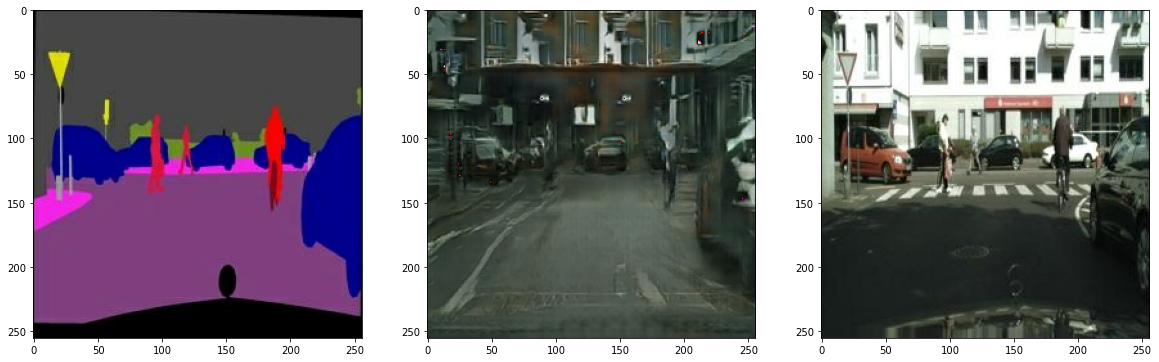

In [28]:
test_ind = 1
data_path = os.getenv("HOME")+"/aiffel/cityscapes/val/"
f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항
상세기준
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.


2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.

U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.


3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

### 회고

이번 노드는 pix2pix의 개념을 배울 수 있었습니다. 랜덤하게 이미지를 생성하는 것이 아닌 일정한 방향을 제시해 주는 모델을 학습하여 생성하는 모델이었습니다. 노드에 주어진 코드를 활용하면 되었기 때문에 크게 어려운 점은 없었지만, 데이터의 형태(라벨과 스케치)가 바뀌었기 때문에 해당 부분을 수정하는 데 다소 시간이 걸렸습니다. 그리고 기준으로 잡았던 10회 에포크의 경우 결과물에 노이즈가 있는것처럼 제대로 출력되지 않았기 때문에 epoch 300회로 재설정하여 보다 사진에 가까운 이미지를 얻을 수 있었습니다. 학습에 시간이 많이 걸렸습니다. 